# COMP4030 - Data Science and Machine Learning - Coursework 2

## Data collection and pre-processing
At this stage you can toggle which gestures you want to include in the training and testing by adding or removing elements from this functions return array.

In [1]:
def get_gestures():
      return ['circle', 'go', 'come', 'wave'] # 

In [2]:
# Utility functions - Ashley Hunt - psyah10
import os

def get_gestures():
      return ['circle', 'come', 'go', 'wave']

def num_gestures():
      return len(get_gestures())

def get_columns():
    return ['time', 'accel_x', 'accel_y', 'accel_z', 'accel_abs']

def get_gesture_csvs(gesture_dir):
      if not os.path.exists(gesture_dir):
            os.makedirs(gesture_dir)
      return [file for file in os.listdir(gesture_dir) if file.endswith('.csv')]

### Data Importing
Next we read the raw data from the CSV files and place the data inside a pandas DataFrame. 

In [3]:
# Data importing functions - Ashley Hunt - psyah10
import pandas as pd

## Simple function to read a csv file and return a dataframe - If scaler is provided, it will scale the data
def get_df(path, trim=True):
      if not path.endswith('.csv'):
            return []
      
      raw_data = pd.read_csv(path)
      raw_data.columns = get_columns()

      df = pd.DataFrame(raw_data, columns=raw_data.columns)

      return trim_recording(df) if trim else df

## Function to trim the recording to the first and last significant movement
def trim_recording(df, window_size = 20, threshold = 0.3, padding=90):

      df['rolling_max'] = df['accel_abs'].rolling(window=window_size, min_periods=1).mean()

      start_cut = df[df['rolling_max'] >= threshold].index.min()
      if pd.notna(start_cut):
            cut_index = max(start_cut - padding, 0)
            df = df.loc[cut_index:]
      
      end_cut = df[df['rolling_max'] >= threshold].index.max()
      if pd.notna(end_cut):
            end_cut_index = min(end_cut + padding, len(df) - 1) 
            df = df.loc[:end_cut_index]

      df = df.drop('rolling_max', axis=1)
      return df

## Function to get all the data from the files in the data folder
def get_data_from_files(trim=True, test=False):
      dfs = []
      gestures = get_gestures()
      if test:
            gestures.append('unknown')
      for gesture in gestures:
            folder_path = f'data/{gesture}' if not test else f'data/test/{gesture}/'
            files_in_folder = get_gesture_csvs(folder_path)
            if len(files_in_folder) == 0:
                  continue
            for file_index, file_name in enumerate(files_in_folder):
                  file_path = os.path.join(folder_path, file_name)
                  df = get_df(file_path, trim)
                  if len(df) == 0:
                        continue

                  df['file_number'] = int(file_index)
                  df['gesture'] = str(gesture)

                  dfs.append(df)
                  
      df = pd.concat(dfs, ignore_index=True) if len(dfs) > 1 else dfs[0]
      df.set_index(['gesture', 'file_number'], inplace=True)
      df.sort_index(inplace=True)
      return df

In [4]:
# Data importing - Ashley Hunt - psyah10

df = get_data_from_files(trim=False, test=False)
df

time   accel_x   accel_y   accel_z  accel_abs
gesture file_number                                                    
circle  0            -0.000168 -0.788251  0.130375 -0.509369   0.947520
        0             0.009792 -0.650429  0.326645 -1.169877   1.377812
        0             0.019752 -0.054111  0.559245 -1.409727   1.517569
        0             0.029712  0.283562  0.759787 -0.788114   1.130844
        0             0.039672  0.576549  1.077596 -0.190112   1.236837
...                        ...       ...       ...       ...        ...
wave    3            18.162669 -0.104021 -0.025044 -0.008408   0.107323
        3            18.172630 -0.036461 -0.014775  0.161020   0.165757
        3            18.182591 -0.076107  0.037350  0.275024   0.287794
        3            18.192552 -0.209477  0.062328  0.007617   0.218686
        3            18.202513 -0.203090 -0.002583 -0.255974   0.326764

[31903 rows x 5 columns]

### Data Balancing
In order to ensure a balanced data set we find the minimum number of file contributions for each gesture and only take that number of files for every gesture.

In [5]:
# Balance distribution functions - Ashley Hunt - psyah10

def balance_files(df):
      for gesture in df.index.get_level_values('gesture').unique():
            num_files = len(df.loc[(gesture), :].index.unique())
            print(f'{gesture} has {num_files} files (approx. {num_files * 8} gestures)')
            
      min_num_files = df.reset_index().groupby('gesture')['file_number'].nunique().min()
      print(f'\nAverage number of files per gesture: {min_num_files}')
      
      unique_file_numbers = df.index.get_level_values('file_number').unique()
      if len(unique_file_numbers) > min_num_files:
            remove = unique_file_numbers[min_num_files]
            balanced_df = df[df.index.get_level_values('file_number') < remove]
            print(f'\nRemoved from dataset where file_number >= {remove}')
      else :
            balanced_df = df
      
      return balanced_df

In [6]:
# Balance distribution - Ashley Hunt - psyah10
df = balance_files(df)
df

circle has 4 files (approx. 32 gestures)
come has 4 files (approx. 32 gestures)
go has 4 files (approx. 32 gestures)
wave has 4 files (approx. 32 gestures)

Average number of files per gesture: 4


time   accel_x   accel_y   accel_z  accel_abs
gesture file_number                                                    
circle  0            -0.000168 -0.788251  0.130375 -0.509369   0.947520
        0             0.009792 -0.650429  0.326645 -1.169877   1.377812
        0             0.019752 -0.054111  0.559245 -1.409727   1.517569
        0             0.029712  0.283562  0.759787 -0.788114   1.130844
        0             0.039672  0.576549  1.077596 -0.190112   1.236837
...                        ...       ...       ...       ...        ...
wave    3            18.162669 -0.104021 -0.025044 -0.008408   0.107323
        3            18.172630 -0.036461 -0.014775  0.161020   0.165757
        3            18.182591 -0.076107  0.037350  0.275024   0.287794
        3            18.192552 -0.209477  0.062328  0.007617   0.218686
        3            18.202513 -0.203090 -0.002583 -0.255974   0.326764

[31903 rows x 5 columns]

### Unseen Test data
Alongside our labelled data sets we also process additional, unlabelled data that will not be seen my the model as it trains and will be used for validation only.

In [7]:
# Test data importing - Ashley Hunt - psyah10

test_df = get_data_from_files(trim=False, test=True)
test_df = balance_files(test_df)
test_df

circle has 1 files (approx. 8 gestures)
come has 1 files (approx. 8 gestures)
go has 1 files (approx. 8 gestures)
wave has 1 files (approx. 8 gestures)

Average number of files per gesture: 1


time   accel_x   accel_y   accel_z  accel_abs
gesture file_number                                                    
circle  0             0.004453 -0.444350  1.202328 -0.574838   1.404805
        0             0.014413 -0.478790  1.627338 -0.770959   1.863289
        0             0.024374  0.042693  1.753948 -0.964582   2.002143
        0             0.034334  0.277987  2.015396 -1.015289   2.273744
        0             0.044294  0.725458  2.291303 -0.788502   2.529445
...                        ...       ...       ...       ...        ...
wave    0            19.369377 -0.062842 -0.071761  0.046431   0.106088
        0            19.379338 -0.151788 -0.037644  0.056115   0.166149
        0            19.389298 -0.130972 -0.017545  0.010476   0.132557
        0            19.399259 -0.177623  0.059601 -0.172971   0.254992
        0            19.409220 -0.012190  0.065868 -0.320356   0.327284

[8193 rows x 5 columns]

### Data visualisation and exploration
Next we visualise our raw data for exploratory analysis

In [8]:
# Visualising data functions - Ashley Hunt - psyah10
import matplotlib.pyplot as plt

def visualise_df(dataframe, columns, files_per_gesture=2):
    fig, axs = plt.subplots(num_gestures(), files_per_gesture, figsize=(17, num_gestures() * 4))
    
    files = min(len(dataframe.index.get_level_values('file_number').unique()), files_per_gesture)

    for (gesture, file_number), group in dataframe.loc[(slice(None), range(0,files)), :].groupby(level=['gesture', 'file_number']):

            ax =  axs[get_gestures().index(gesture), file_number] if files_per_gesture > 1 else axs[get_gestures().index(gesture)]

            for col in columns:
                ax.plot(range(0, len(group)), group[col], label=col)
                ax.set_title("{gesture} {file_number}".format(gesture=gesture, file_number=file_number))
                ax.set_xlabel('Index')
                ax.set_ylabel('Acceleration')
                ax.legend()
            
    plt.tight_layout()
    plt.show()

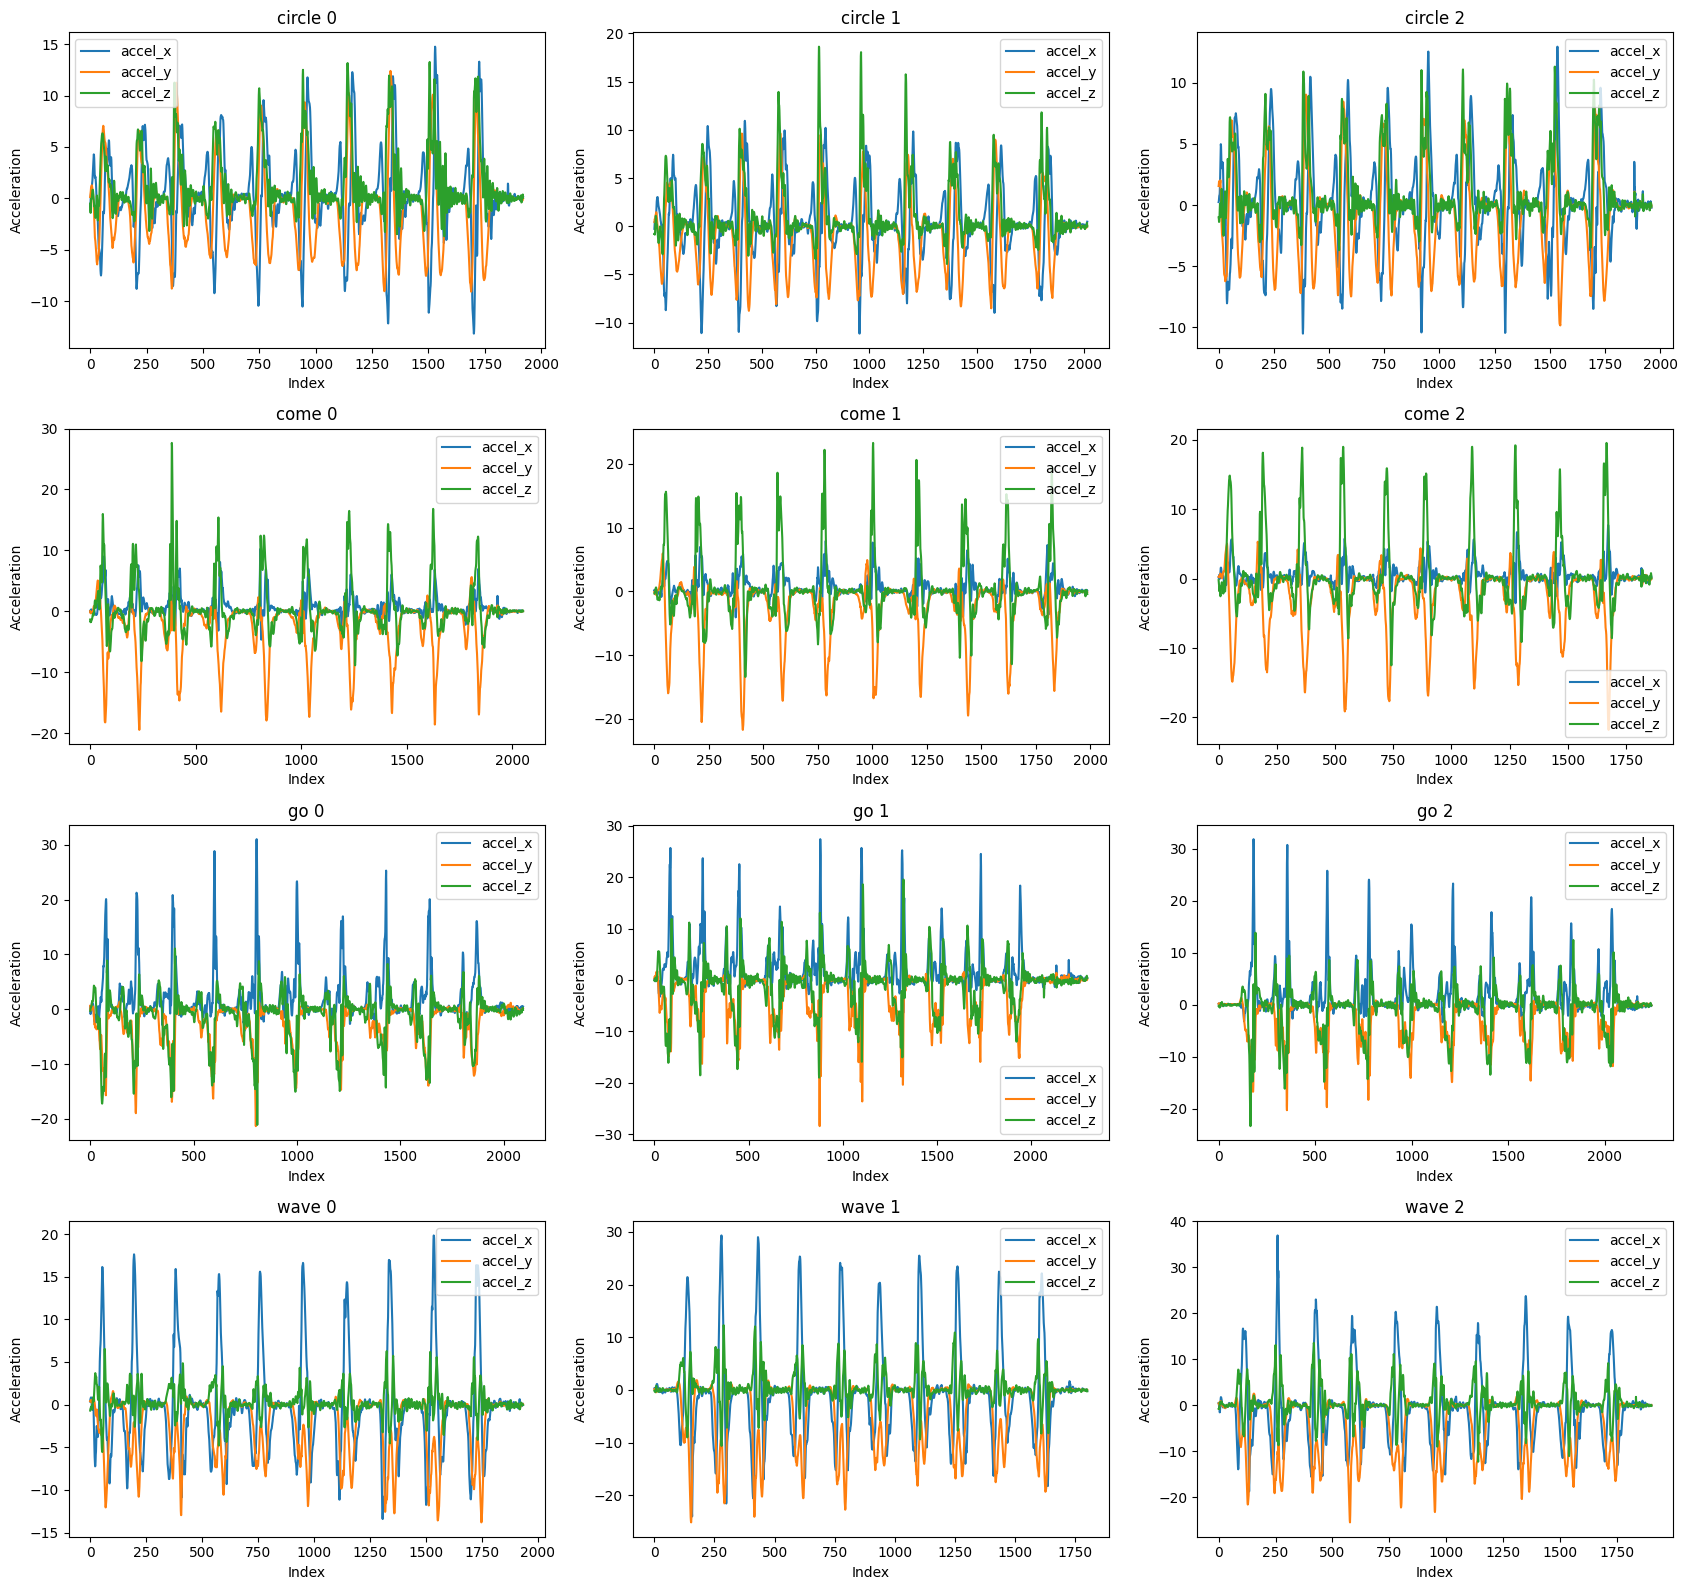

In [9]:
visualise_df(df, ['accel_x', 'accel_y', 'accel_z'], files_per_gesture=3)

### EWMA Filtering
To eradicate spikes in the data, we apply exponentially weighted moving average (EWMA)

In [10]:
# Apply exponential moving average - Ashley Hunt - psyah10
df = df.ewm(span=10, adjust=False).mean()

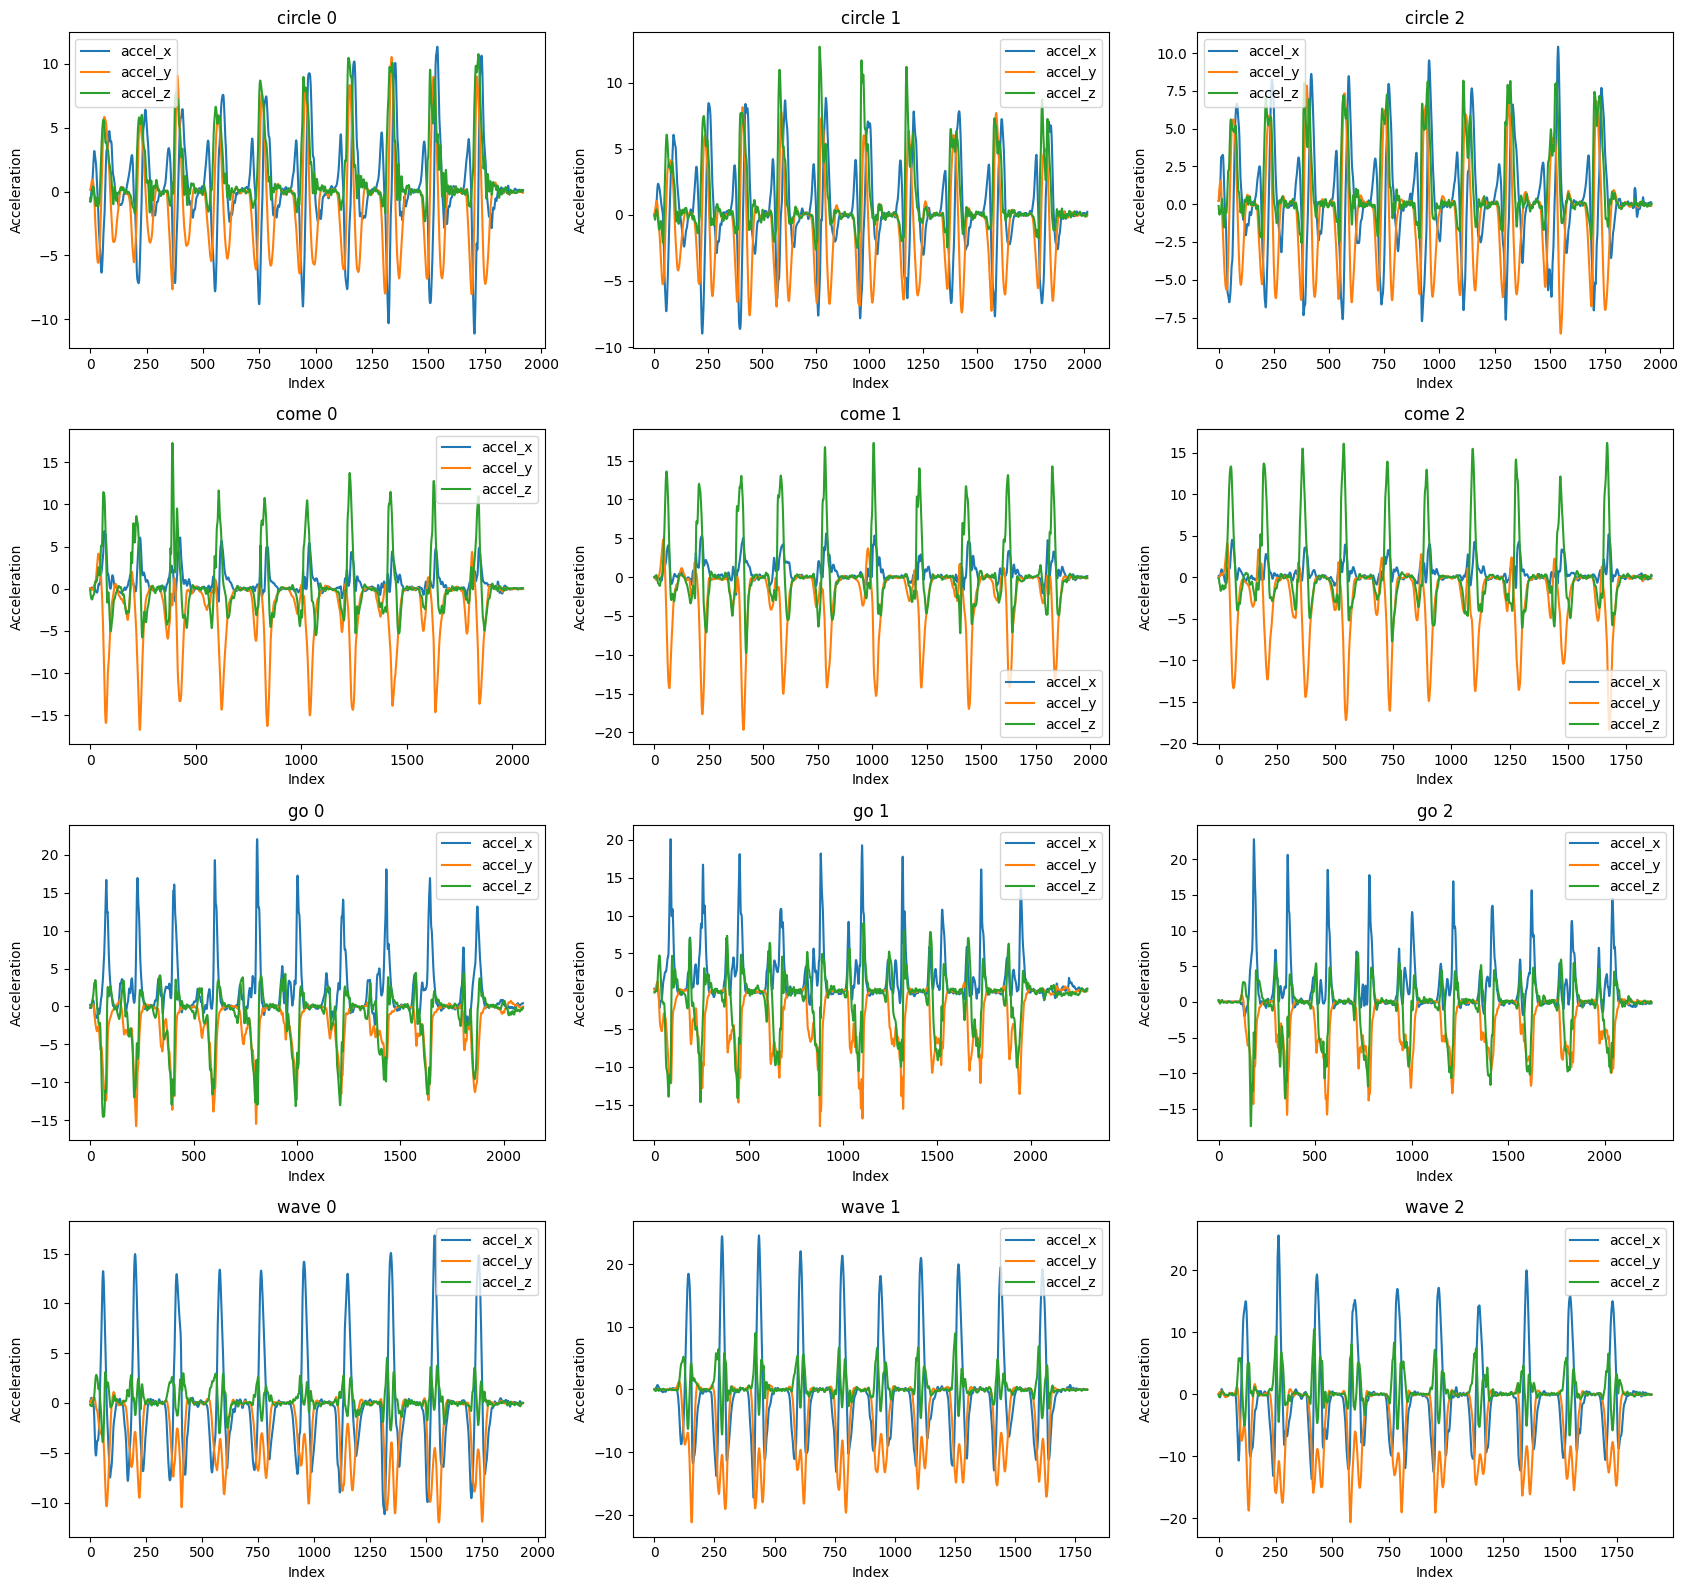

In [11]:
# First on the main data
visualise_df(df, ['accel_x', 'accel_y', 'accel_z'], files_per_gesture=3)

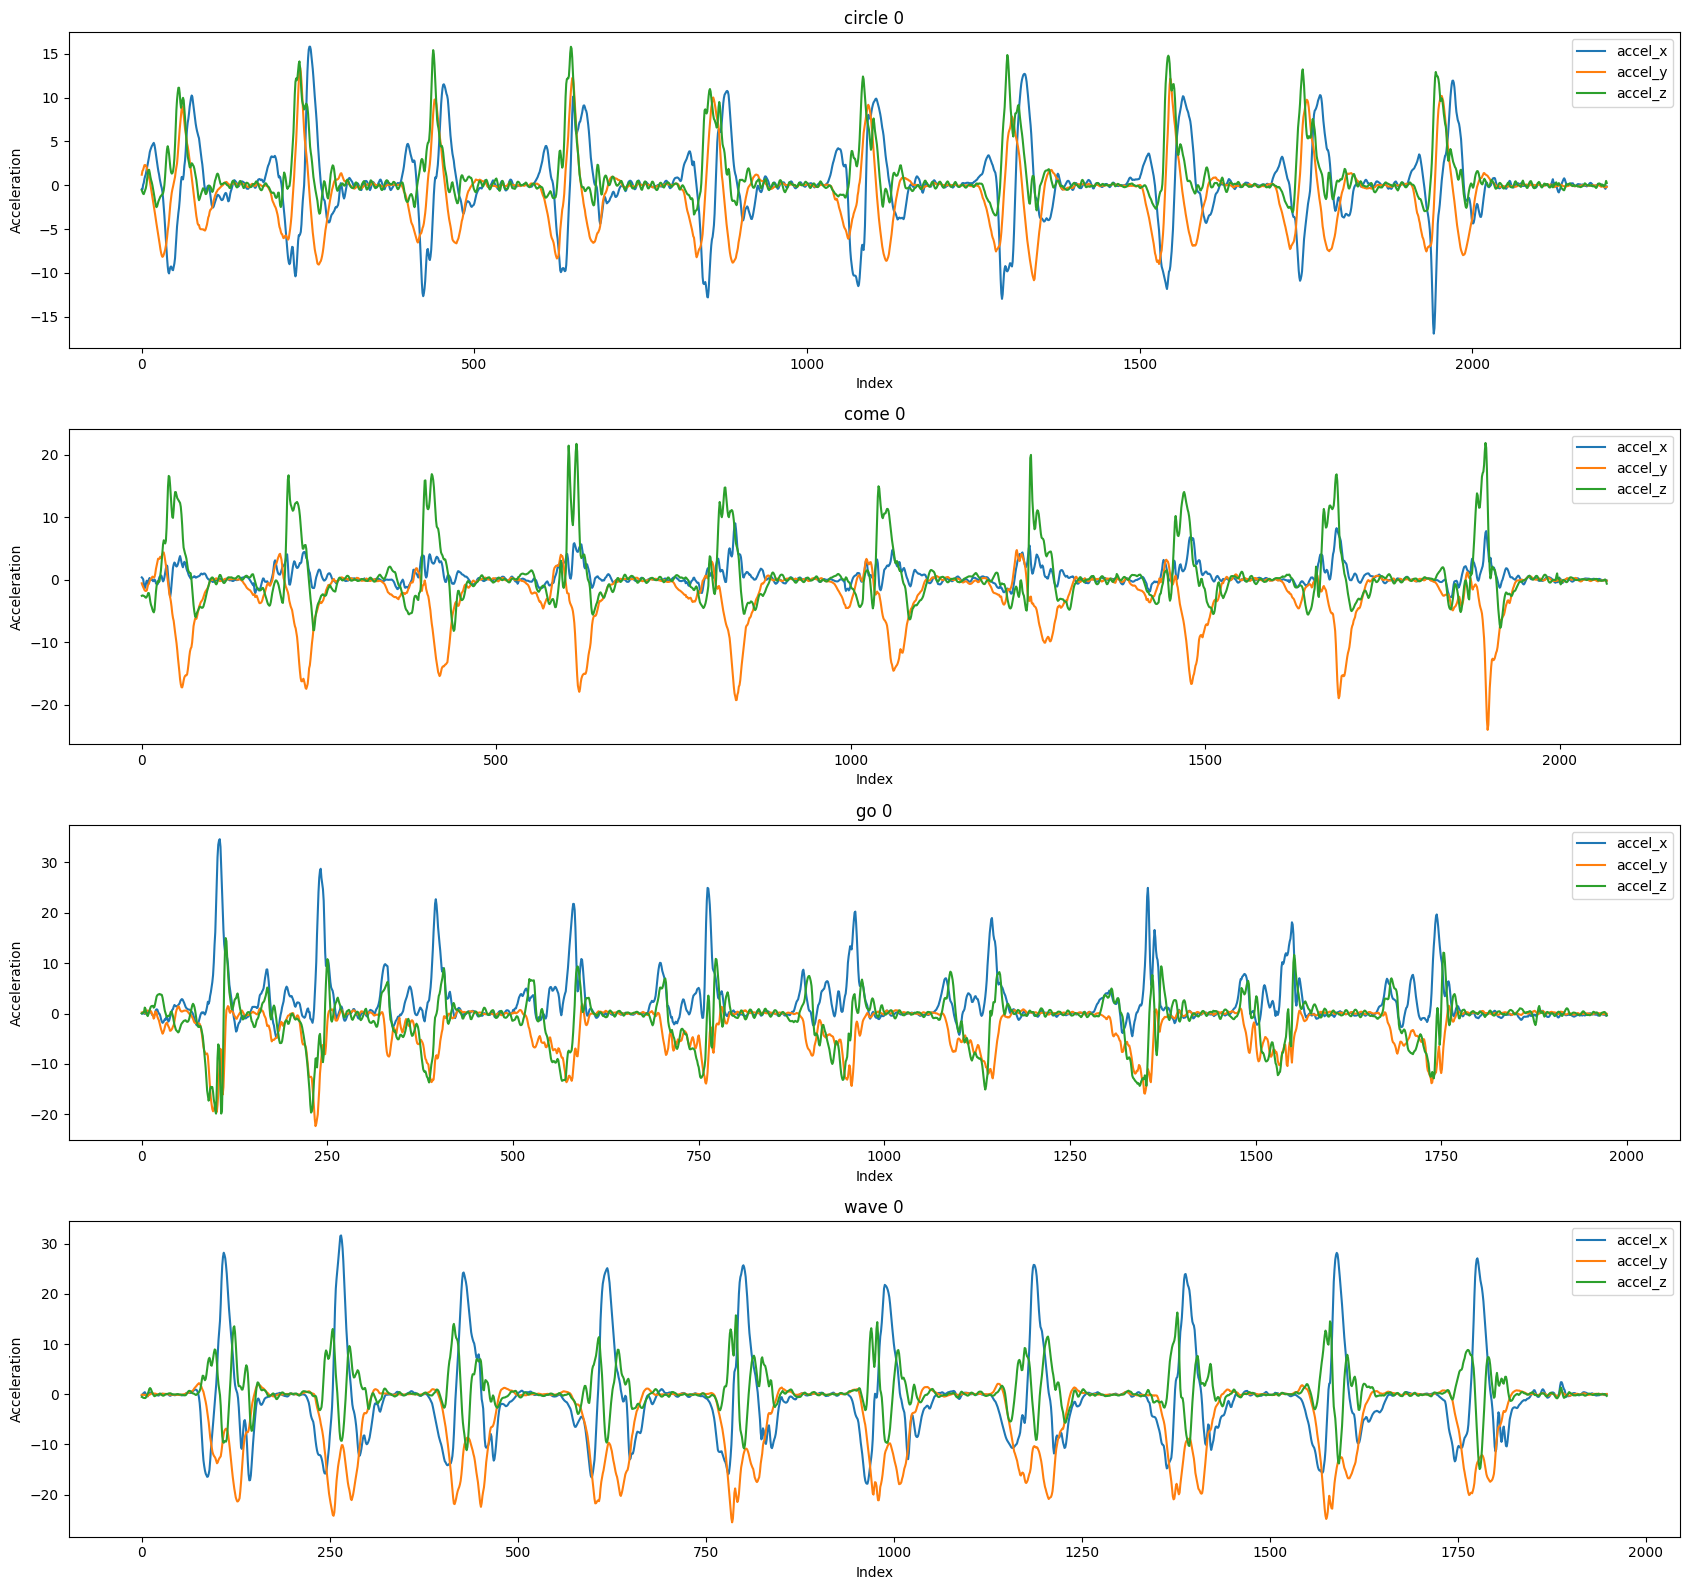

In [12]:
# Secondly on the unseen test data
visualise_df(test_df, ['accel_x', 'accel_y', 'accel_z'], files_per_gesture=1)

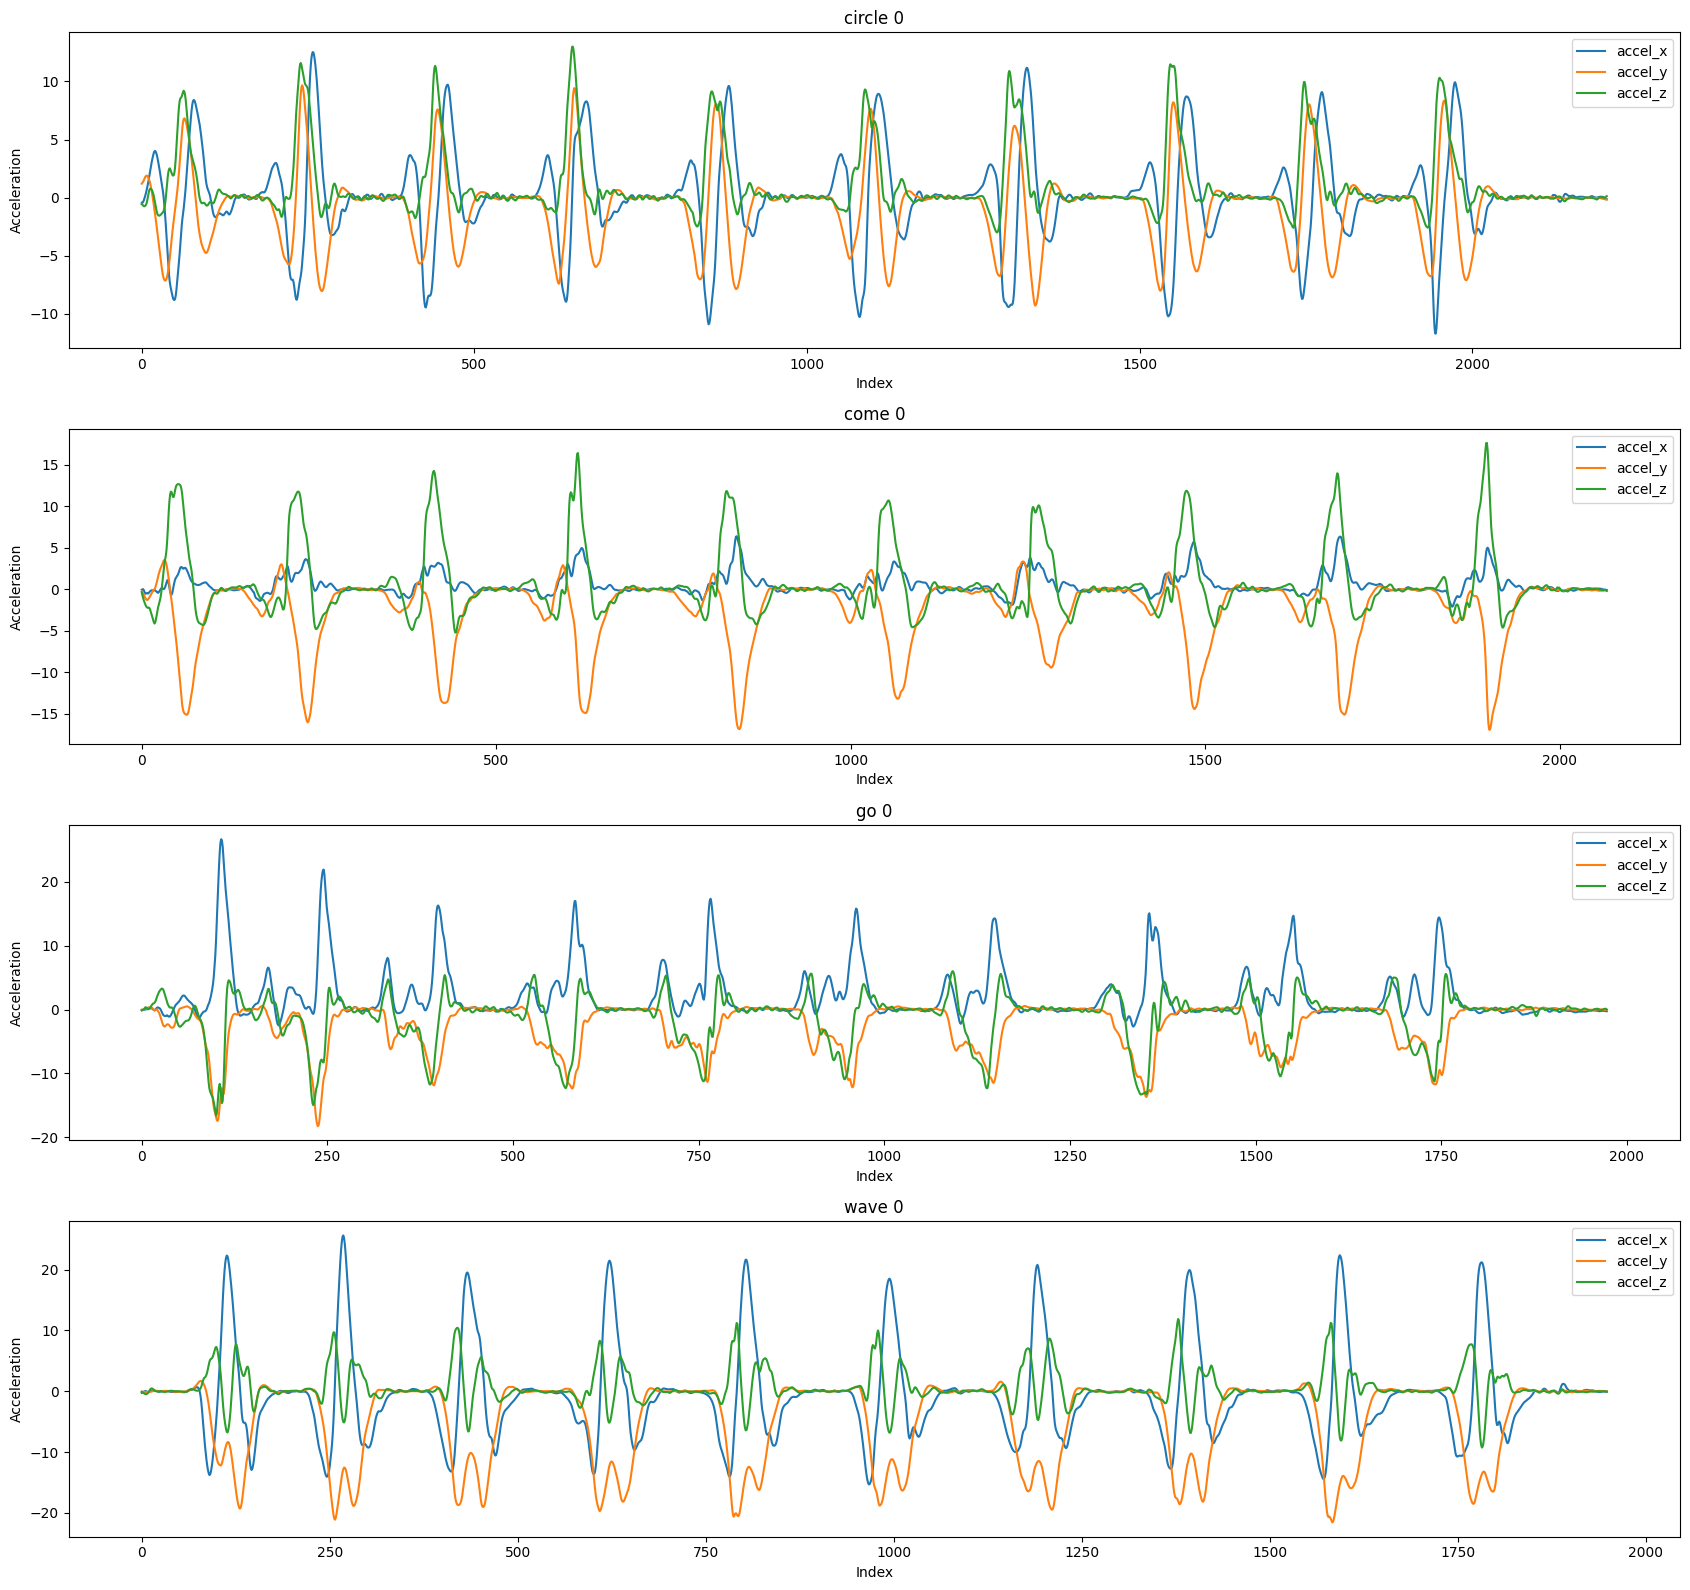

In [13]:
test_df = test_df.ewm(span=10, adjust=False).mean()
visualise_df(test_df, ['accel_x', 'accel_y', 'accel_z'], files_per_gesture=1)

### Low-Pass Filtering
Next we apply a low-pass filter to reduce noise from the data and make our model more robust. First we visualise our data and using interactive widgets we visually evaluate the performance of different parameter settings for apply the filter.

In [14]:
# Low-pass filtering functions - Ashley Hunt - psyah10
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def apply_filter(df, cutoff_freq=2, fs=50, order=5):
    new_df = df.copy()
    for column in get_columns()[1:]:
        new_df[column] = butter_lowpass_filter(new_df[column], cutoff_freq, fs, order)
    return new_df

In [15]:
# Visualising data functions - Ashley Hunt - psyah10
import matplotlib.pyplot as plt

def df_preview(dataframe, files_per_gesture=2):
    
    plt.clf()
    
    fig, axs = plt.subplots(num_gestures(), files_per_gesture, figsize=(15, files_per_gesture * 4))

    for (gesture, file_number), group in dataframe.loc[(slice(None), range(0, files_per_gesture)), :].groupby(level=['gesture', 'file_number']):

            ax = axs[get_gestures().index(gesture), file_number]

            for col in get_columns()[1:4]:
                ax.plot(range(0, len(group)), group[col], label=col)
                ax.set_title("{gesture} {file_number}".format(gesture=gesture, file_number=file_number))
                ax.set_xlabel('Index')
                ax.set_ylabel('Acceleration')
                ax.legend()
            
    plt.tight_layout()
    plt.show()

In [16]:
# Interactive filter parameter tuning - Ashley Hunt - psyah10
%matplotlib inline
import ipywidgets as widgets
from IPython.display import display

cutoff_frequency_slider = widgets.IntSlider(value=3, min=1, max=15, step=1, description='cutoff_frequency')
sampling_rate_slider = widgets.IntSlider(value=150, min=25, max=150, step=1, description='sampling_rate')
filter_order_slider = widgets.IntSlider(value=3, min=1, max=100, step=1, description='filter_order')

def update_signal(cutoff_frequency, sampling_rate, filter_order):
    filtered_df = apply_filter(df, cutoff_frequency, sampling_rate, filter_order)
    df_preview(filtered_df, files_per_gesture=2)

interactive_plot = widgets.interactive(update_signal, cutoff_frequency=cutoff_frequency_slider, sampling_rate=sampling_rate_slider, filter_order=filter_order_slider)
display(interactive_plot)


interactive(children=(IntSlider(value=3, description='cutoff_frequency', max=15, min=1), IntSlider(value=150, …

Using the best parameters we then apply these settings to our data

In [17]:
# Filter parameter tuning - Ashley Hunt - psyah10

cutoff_frequency = 3  # Cutoff frequency in Hz - Higher = less smoothing
sampling_rate = 100  # Sampling rate in Hz - Higher = more smoothing
filter_order = 3  # Filter order - Higher = less smoothing

df = apply_filter(df, cutoff_frequency, sampling_rate, filter_order)
test_df = apply_filter(test_df, cutoff_frequency, sampling_rate, filter_order)

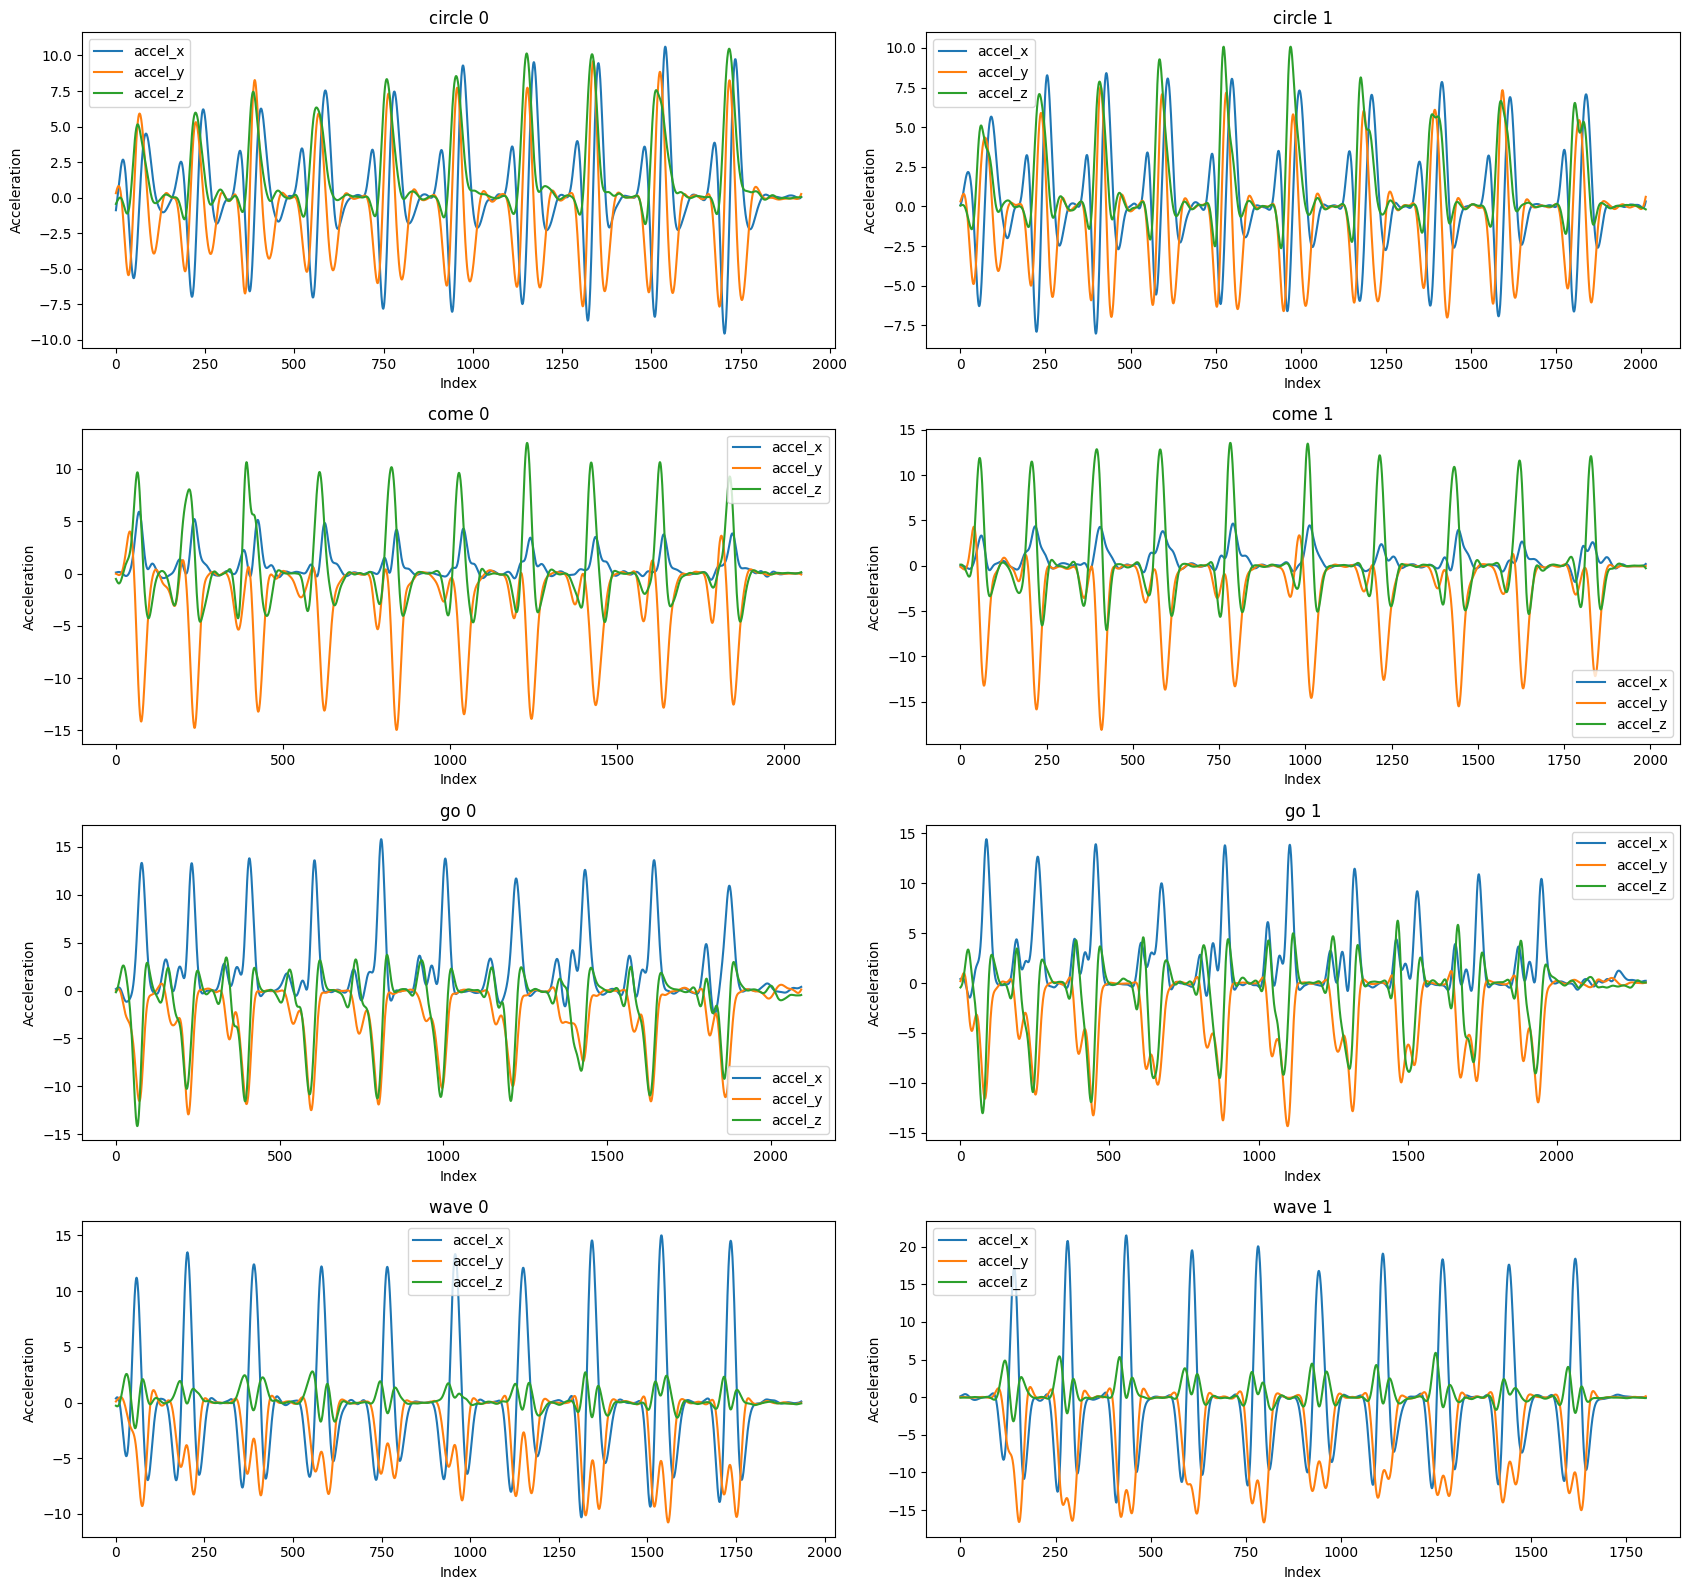

In [18]:
visualise_df(df, ['accel_x', 'accel_y', 'accel_z'], files_per_gesture=2)

### Data Normalisation

At this point we also normalise our data using a MinMaxScaler, ensuring that all of our data lies between 0 and 1. This will ensure that no single field plays a more important role than it should.

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() ## StandardScaler() or MinMaxScaler()

df[get_columns()] = scaler.fit_transform(df[get_columns()])

test_df[get_columns()] = scaler.fit_transform(test_df[get_columns()])

### Gesture segmentation
Now we split the data from distinct files into distinct gestures. We do this by using the natural peaks and troughs in absolute acceleration.

In [20]:
# Spltting gestures functions - Ashley Hunt - psyah10
from scipy.signal import find_peaks

def split_file_to_gestures(df, threshold=0.03, padding=10):
      gesture_data = []
      charts = []
      for (gesture, file_number), group in df.groupby(level=['gesture', 'file_number']):
            
            charts.append(gesture) ## Limit to 2 charts per gesture
            
            group.reset_index(drop=True, inplace=True)
            group.drop(['time'], axis=1, inplace=True)
            
            peaks, peak_info = find_peaks(group['accel_abs'], height=0.25, distance=20, width=26, prominence=0.1)
            
            if(len(peaks) < 6 or len(peaks) > 10):
                  print(f"Incorrect peaks in {gesture} {file_number} - {len(peaks)}")
                  plt.plot(group['accel_abs'])
                  plt.plot(peaks, group['accel_abs'][peaks], "x")
                  plt.title(f'{gesture} {file_number}')
                  plt.show()
            
            for peak in peaks:
                  
                  below_target = group.loc[:peak]
                  start_index = below_target[below_target['accel_abs'] < threshold].last_valid_index() #or 0
                  start_index = max(0, start_index - padding)
                  
                  above_target = group.loc[peak + 1:]
                  end_index = above_target[above_target['accel_abs'] < threshold].first_valid_index() #or len(group) - 1
                  end_index = min(len(group), end_index + padding)
                  
                  data = group.loc[start_index:end_index].copy()
                  
                  data['gesture_number'] = len(gesture_data)
                  data['gesture'] = gesture
                  gesture_data.append(data)
      
      gesture_df = pd.concat(gesture_data, ignore_index=True)
      gesture_df.set_index(['gesture', 'gesture_number'], inplace=True)
      return gesture_df

In [21]:
# Spltting gestures - Ashley Hunt - psyah10

gesture_df = split_file_to_gestures(df, threshold=0.07, padding=10)
gesture_df

accel_x   accel_y   accel_z  accel_abs
gesture gesture_number                                         
circle  0               0.368480  0.687142  0.502407   0.036352
        0               0.374006  0.690535  0.504277   0.038887
        0               0.379746  0.693758  0.506115   0.041588
        0               0.385690  0.696718  0.507908   0.044482
        0               0.391820  0.699317  0.509641   0.047590
...                          ...       ...       ...        ...
wave    159             0.368666  0.680424  0.515238   0.044451
        159             0.371469  0.679618  0.516360   0.041523
        159             0.374136  0.678915  0.517449   0.038841
        159             0.376674  0.678313  0.518492   0.036400
        159             0.379090  0.677807  0.519479   0.034195

[21043 rows x 4 columns]

In [22]:
# Spltting gestures on test data - Ashley Hunt - psyah10

test_gesture_df = split_file_to_gestures(test_df, threshold=0.07, padding=10)

In [23]:
test_gesture_df

accel_x   accel_y   accel_z  accel_abs
gesture gesture_number                                         
circle  0               0.381511  0.777480  0.499559   0.044407
        0               0.387653  0.780160  0.502348   0.048638
        0               0.394071  0.782559  0.505016   0.052961
        0               0.400771  0.784550  0.507541   0.057383
        0               0.407750  0.786002  0.509892   0.061908
...                          ...       ...       ...        ...
wave    39              0.367329  0.738027  0.518011   0.043363
        39              0.370443  0.736603  0.518657   0.040267
        39              0.373403  0.735193  0.519174   0.037475
        39              0.376223  0.733829  0.519557   0.034965
        39              0.378908  0.732536  0.519803   0.032716

[5127 rows x 4 columns]

Now we visualise these gestures.

In [24]:
# Visualising gesture functions - Ashley Hunt - psyah10

def visualise_gestures(dataframe, n):
      charts = []
      plt.figure(figsize=(n * 4, 10))
      for (gesture, gesture_number), group in dataframe.groupby(level=['gesture', 'gesture_number']):
            
            charts.append(gesture) ## Limit charts per gesture
            if(charts.count(gesture) > n):
                  continue
            
            gesture_i = len(pd.Series(charts).unique()) - 1
            plt.subplot(num_gestures(), n, (n * gesture_i ) + charts.count(gesture) )
            
            group.reset_index(drop=True, inplace=True)
            for col in get_columns()[1:4]:
                  plt.plot(range(len(group)), group[col], label=col)
                  plt.title("{gesture} {gesture_number}".format(gesture=gesture, gesture_number=gesture_number))
                  plt.legend()
                  plt.ylim(0, 1)
      plt.subplots_adjust(hspace=0.4)
      plt.show()

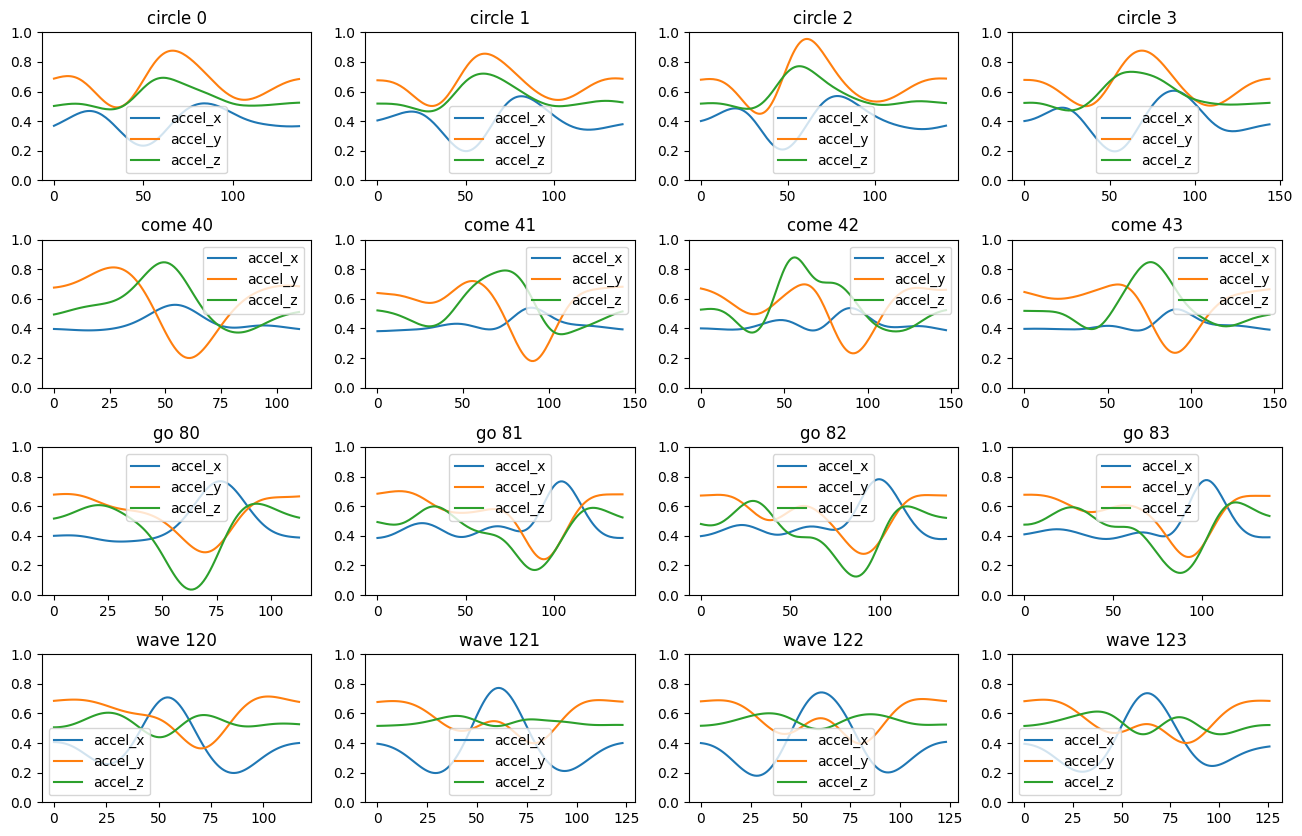

In [25]:
# Visualising data - Ashley Hunt - psyah10

visualise_gestures(gesture_df, 4)

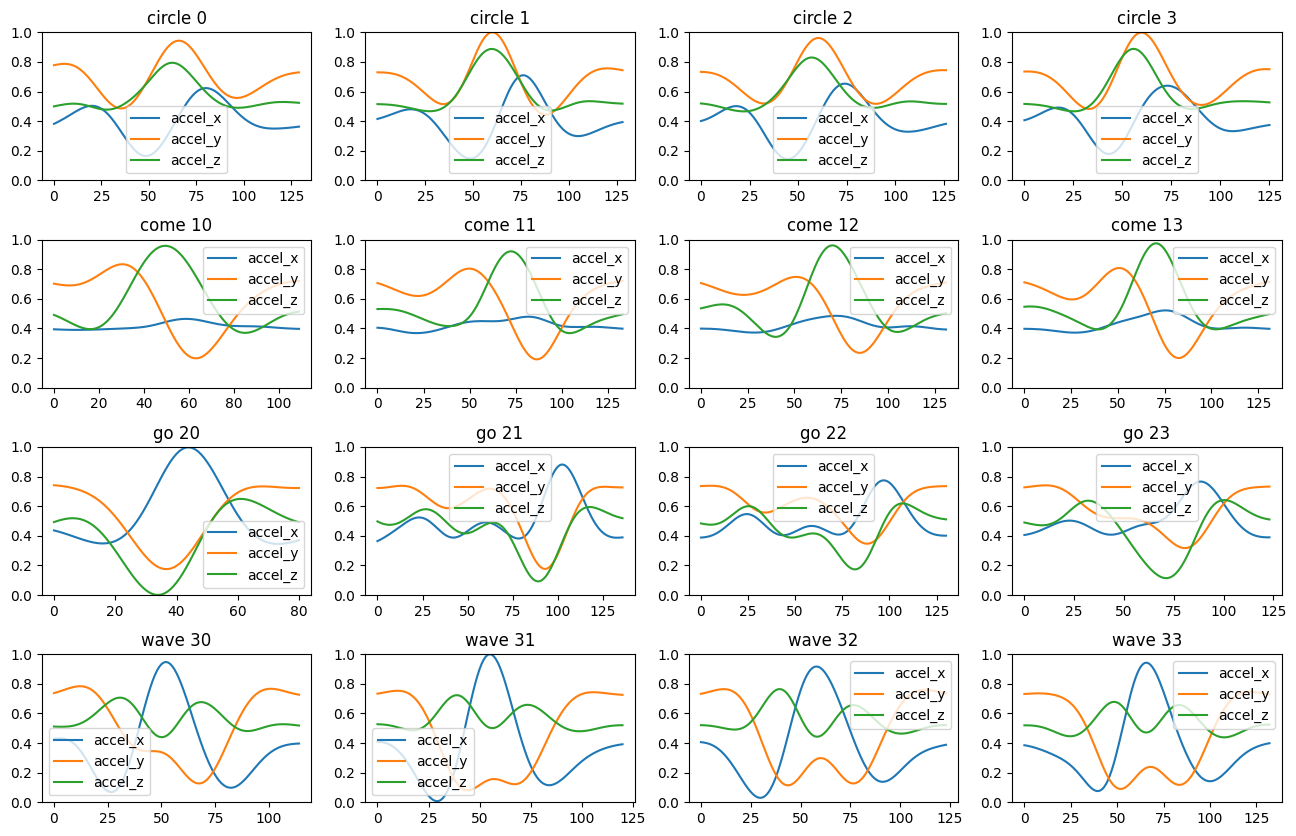

In [26]:
# Visualising test data - Ashley Hunt - psyah10

visualise_gestures(test_gesture_df, 4)

If, due to slicing errors, there are duplicate gestures we will remove them

In [27]:
# Removing duplicate functions - Ashley Hunt - psyah10

def remove_duplicate_gestures(dataframe):
      data = dataframe.copy()
      
      data_columns = get_columns()[1:]
      group_columns = ['gesture', 'gesture_number']

      grouped = data.groupby(group_columns)

      group_representations = {}
      duplicates_found = False
      for name, group in grouped:
            group_tuple = tuple(group.sort_values(by=data_columns)[data_columns].itertuples(index=False, name=None))
            
            if group_tuple in group_representations:
                  duplicates_found = True
                  data = data.drop(name)
                  print("Removing identical gestures", name, "and", group_representations[group_tuple])
            group_representations[group_tuple] = name
            
      if not duplicates_found:
            print("No duplicate gestures found")
      return data

In [28]:
# Removing duplicate slices - Ashley Hunt - psyah10

gesture_df = remove_duplicate_gestures(gesture_df)
test_gesture_df = remove_duplicate_gestures(test_gesture_df)

No duplicate gestures found
No duplicate gestures found


### Fourier Transformation & Filtering
Next we apply a Fourier transformation on the data and filter out the frequencies in the data that are not adding useful information. This is achieved using trial and error through visualisation of the wave before and after transformation.

In [29]:
# Fourier Transformation functions - Ashley Hunt - psyah10
import numpy as np

def fft_filter(data, sample_rate, cutoff_freq_low, cutoff_freq_high):
    fft_data = np.fft.fft(data)
    freqs = np.fft.fftfreq(len(data), 1/sample_rate)

    mask = (freqs > cutoff_freq_low) & (freqs < cutoff_freq_high)
    fft_data[~mask] = 0

    filtered_signal = np.fft.ifft(fft_data).real
    return filtered_signal

def apply_fft_filter(data, sample_rate, cutoff_freq_low, cutoff_freq_high):
    new_df = data.copy()
    for column in get_columns()[1:4]:
        new_df[column] = fft_filter(new_df[column], sample_rate, cutoff_freq_low, cutoff_freq_high)
    return new_df

def visually_compare_fft(original_df, filtered_df, visualise_n=3):
      num_rows = len(original_df.index.get_level_values('gesture').unique()) * visualise_n
    
      fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, 2.5 * num_rows))

      for gn, (name, group) in enumerate(original_df.groupby(level='gesture')):
            first_n_gestures = group.index.get_level_values('gesture_number').unique()[:visualise_n]
            data = group[group.index.get_level_values('gesture_number').isin(first_n_gestures)]
            
            for idx, (n, g_data) in enumerate(data.groupby(level='gesture_number')):
                  
                  row = idx + gn * visualise_n
                  ax = axes[row, 0]
                  for col in get_columns()[1:4]:
                        ax.plot(range(len(g_data)), g_data[col], label=col, alpha=0.5)
                  ax.set_title(f"{name}, Gesture #{n}")
                  ax.legend(loc='lower left')

                  ax = axes[row, 1]
                  filtered_data = filtered_df.loc[(name, n)]
                  for col in get_columns()[1:4]:
                        ax.plot(range(len(filtered_data)), filtered_data[col], label=col, linestyle='--')
                  ax.set_title(f'{name}, Gesture #{n} (post FFT)')
                  ax.legend(loc='lower left')

      plt.tight_layout()
      plt.show()

In [30]:
# Fourier Transformation - Ashley Hunt - psyah10
 
sample_rate = 1000  # Sampling rate (Hz)
cutoff_low = 3  # Low cutoff frequency (Hz)
cutoff_high = 90  # High cutoff frequency (Hz)

fft_filtered_gestures_df = apply_fft_filter(gesture_df, sample_rate, cutoff_low, cutoff_high)
fft_test_filtered_gestures_df = apply_fft_filter(test_gesture_df, sample_rate, cutoff_low, cutoff_high)

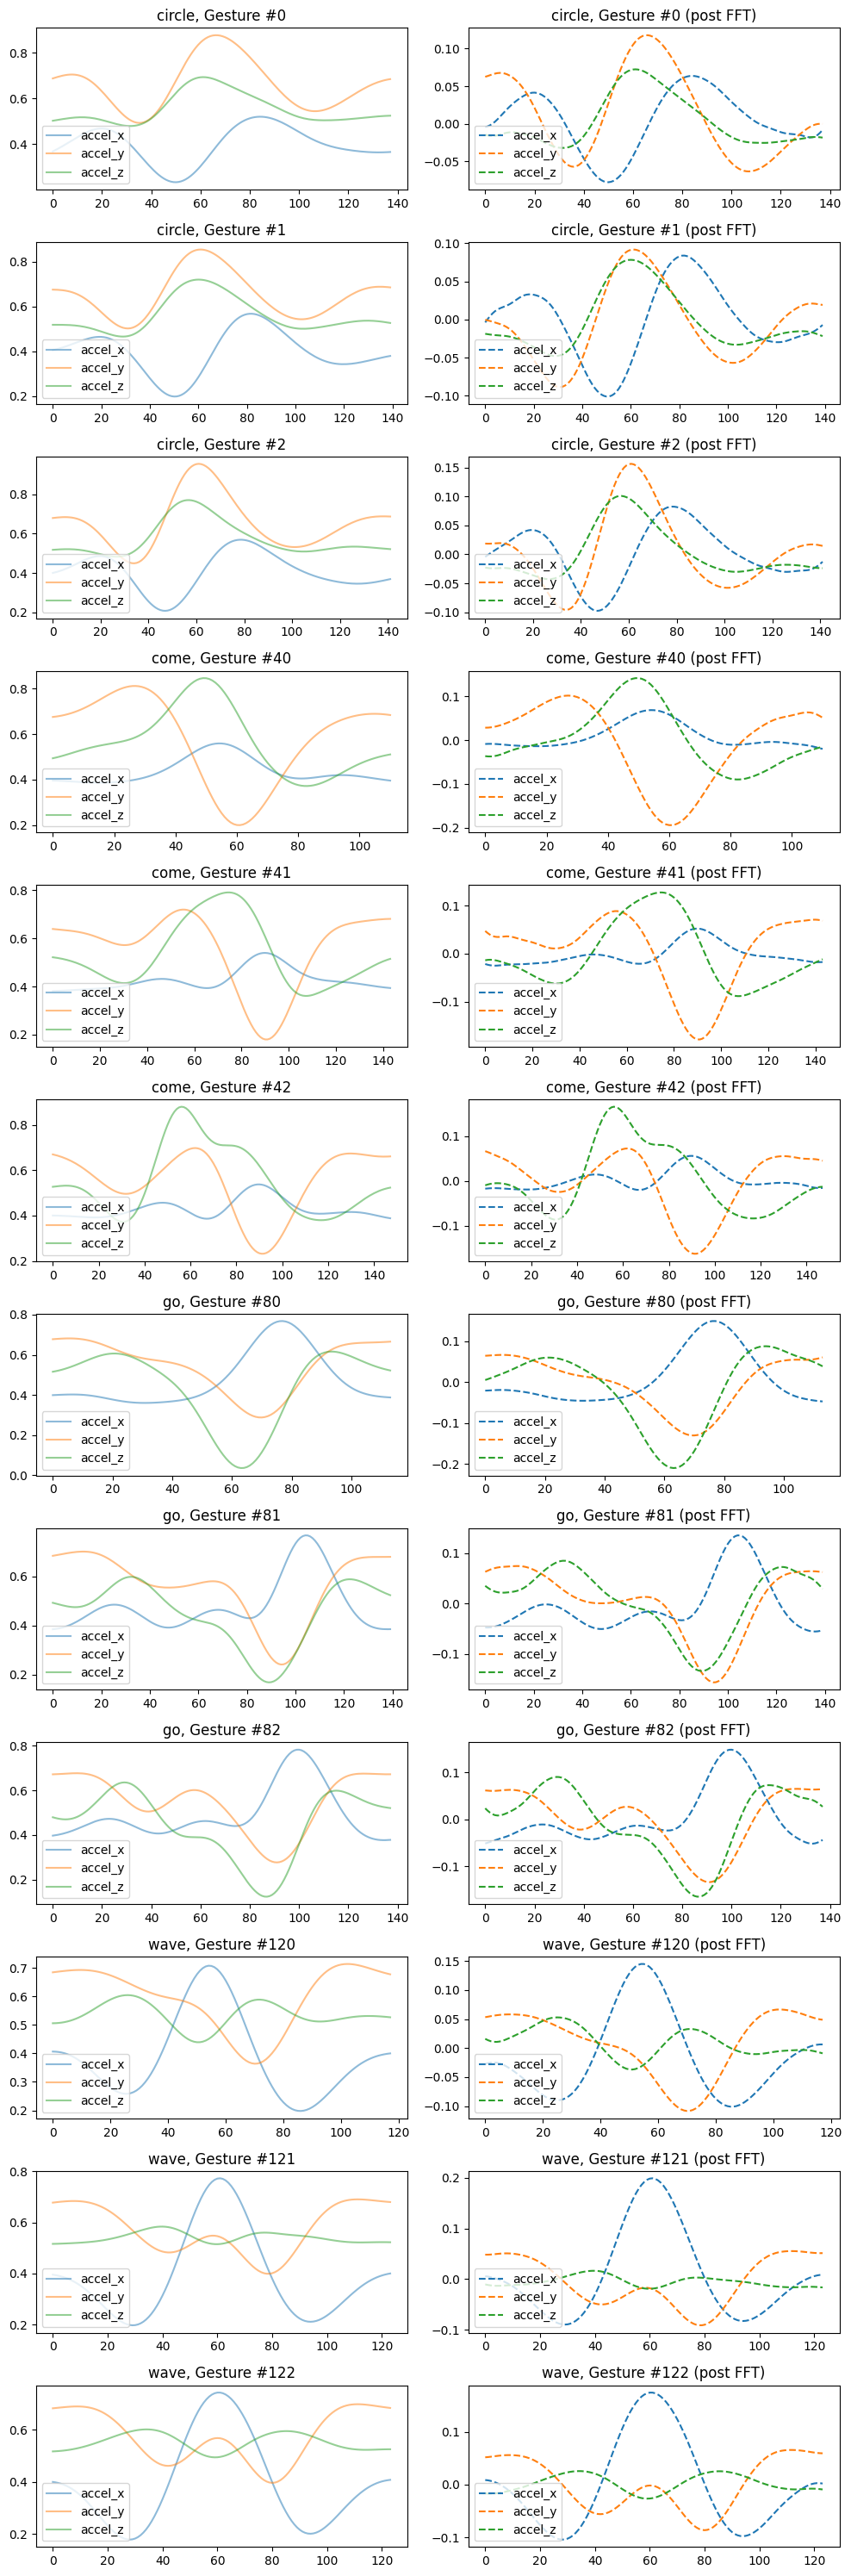

In [31]:
# Visualise the FFT filter alongside the original data
visually_compare_fft(gesture_df, fft_filtered_gestures_df, 3)

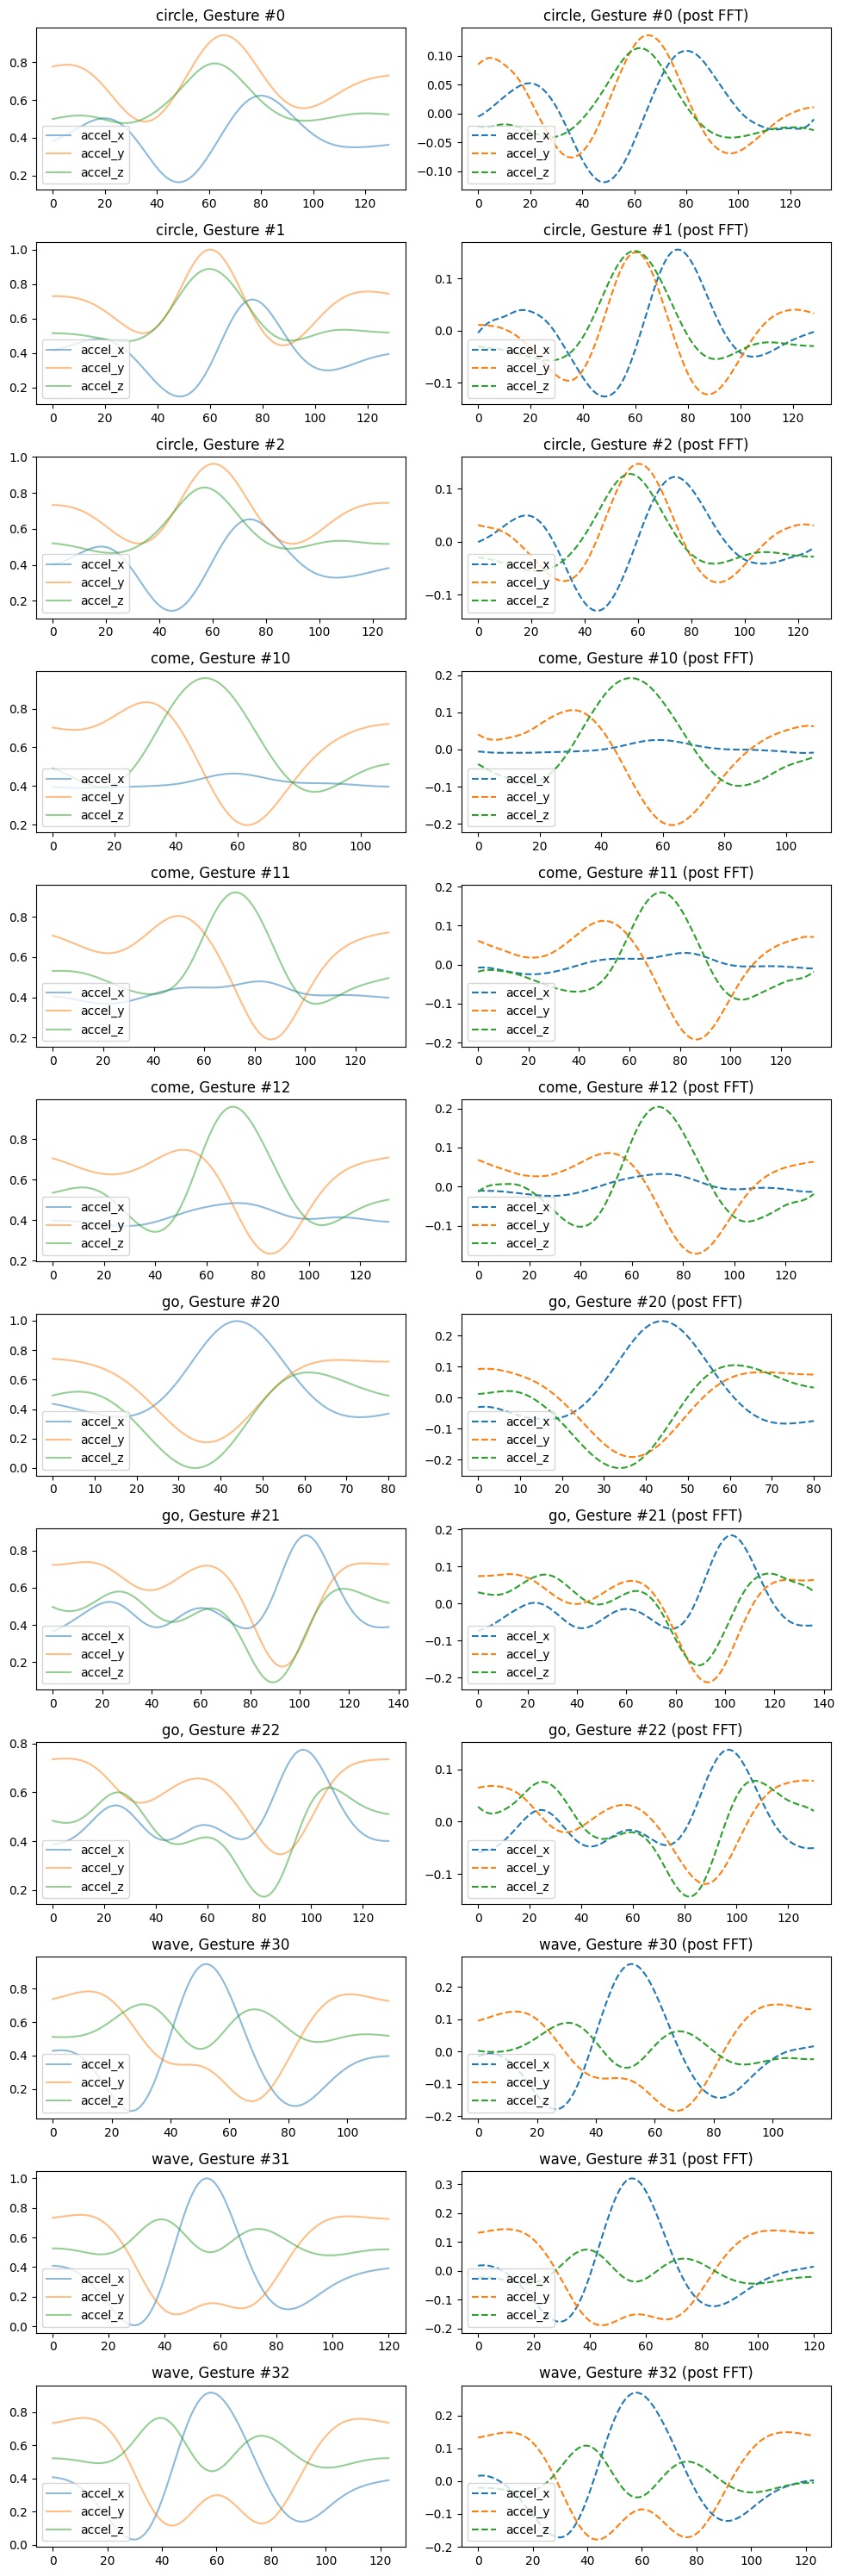

In [32]:
# Visualise the FFT filter alongside the original data (test data)
visually_compare_fft(test_gesture_df, fft_test_filtered_gestures_df, 3)

## Feature Extraction
Next we can begin to extract our features for the models. These functions split the data into a fixed number of segments with some overlap and then take some key statistical values from these slices.

In [33]:
# Feature extraction functions - Ashley Hunt - psyah10

def extract_segments(df, num_segments, overlap_fraction):
    total_rows = len(df)
    segment_size = total_rows // num_segments
    overlap_size = int(segment_size * overlap_fraction)
    
    segments = []
    
    for i in range(num_segments):
        start_idx = i * segment_size
        if i > 0:
            start_idx -= overlap_size
        
        if i == num_segments - 1:
            end_idx = total_rows
        else:
            end_idx = start_idx + segment_size + overlap_size

        segments.append(df.iloc[start_idx:end_idx])
    
    return segments

def extract_features_from_df(df, feature_functions, num_segments = 4, overlap_fraction = 0.1):
      results = []
      
      for (gesture, gesture_number), group in df.groupby(level=['gesture', 'gesture_number']):
            
            group.reset_index(drop=True, inplace=True)

            result_dict = {}
            segments = extract_segments(group, num_segments, overlap_fraction)
            result_dict['gesture'] = gesture
            for n, segment in enumerate(segments):
                  for col in get_columns()[1:4]:
                        for f in feature_functions:
                              result_dict[f'{col}_{f}_{n+1}'] = segment[col].agg(f)

            results.append(result_dict)

      return pd.DataFrame(results)

In [34]:
# Feature extraction - Ashley Hunt - psyah10

# Function options 'mean', 'min', 'max', 'median', 'std', 'skew', 'kurtosis', 'quantile'
feature_functions = ['mean', 'min', 'max', 'median', 'std', 'skew', 'kurtosis', 'quantile'] 
num_segments = 12
overlap_fraction = 0.3

extracted_features = extract_features_from_df(fft_filtered_gestures_df, feature_functions, num_segments, overlap_fraction)
extracted_test_features = extract_features_from_df(fft_test_filtered_gestures_df, feature_functions, num_segments, overlap_fraction)

In [35]:
extracted_features

gesture  accel_x_mean_1  accel_x_min_1  accel_x_max_1  accel_x_median_1  \
0    circle        0.012013      -0.004364       0.031419          0.011223   
1    circle        0.013611      -0.003839       0.026263          0.015193   
2    circle        0.013473      -0.004292       0.031191          0.013452   
3    circle        0.008895      -0.009036       0.027272          0.008251   
4    circle        0.010801      -0.005808       0.028543          0.010319   
..      ...             ...            ...            ...               ...   
155    wave        0.001343      -0.018791       0.010821          0.004803   
156    wave       -0.004729      -0.026331       0.005925         -0.001282   
157    wave       -0.000430      -0.021346       0.009700          0.003056   
158    wave        0.002728      -0.021210       0.013451          0.007395   
159    wave       -0.002063      -0.023261       0.008037          0.001730   

     accel_x_std_1  accel_x_skew_1  accel_x_kurtosis_1  accel_x_quantile_1  \
0         0.012475        0.166988           -1.453545            0.011223   
1         0.008860       -0.574683           -0.354942            0.015193   
2         0.011191       -0.000040           -1.095497            0.013452   
3         0.010771        0.089425           -0.798013            0.008251   
4         0.010668        0.112634           -1.002610            0.010319   
..             ...             ...                 ...                 ...   
155       0.010042       -0.886927           -0.419103            0.004803   
156       0.010781       -0.861700           -0.415341           -0.001282   
157       0.010547       -0.849222           -0.498004            0.003056   
158       0.011816       -0.948069           -0.339231            0.007395   
159       0.010746       -0.853935           -0.545502            0.001730   

     accel_y_mean_1  ...  accel_y_kurtosis_12  accel_y_quantile_12  \
0          0.064245  ...            -1.195872            -0.014559   
1         -0.008139  ...            -0.353576             0.015076   
2          0.017181  ...            -0.381544             0.011035   
3          0.006508  ...            -0.826423             0.011453   
4          0.013588  ...            -0.255500             0.021125   
..              ...  ...                  ...                  ...   
155        0.115352  ...            -1.153485             0.121618   
156        0.113819  ...            -1.518566             0.112076   
157        0.111508  ...            -1.645836             0.114696   
158        0.118138  ...            -1.638178             0.126332   
159        0.128638  ...            -1.417561             0.071208   

     accel_z_mean_12  accel_z_min_12  accel_z_max_12  accel_z_median_12  \
0          -0.020383       -0.024288       -0.017466          -0.020286   
1          -0.017920       -0.022422       -0.015401          -0.017290   
2          -0.020171       -0.023895       -0.017907          -0.019603   
3          -0.029589       -0.031617       -0.028138          -0.029431   
4          -0.025971       -0.029504       -0.024455          -0.025420   
..               ...             ...             ...                ...   
155        -0.023718       -0.025274       -0.022187          -0.023558   
156        -0.016996       -0.020149       -0.015655          -0.016310   
157        -0.015147       -0.021956       -0.008317          -0.014979   
158        -0.006647       -0.012344       -0.002428          -0.005757   
159        -0.013603       -0.015549       -0.011051          -0.013639   

     accel_z_std_12  accel_z_skew_12  accel_z_kurtosis_12  accel_z_quantile_12  
0          0.002362        -0.214046            -1.465164            -0.020286  
1          0.002285        -0.626874            -0.926818            -0.017290  
2          0.002073        -0.618214            -1.020902            -0.019603  
3          0.001265        -0.280867            -1.5

## Feature Selection
Now we visulaise the extracted features to help us determine which features are most useful in classification.

In [36]:
# Visualisting Feature extraction functions - Ashley Hunt - psyah10

def show_trends(dataframe):
      for f in feature_functions:
            plt.figure(figsize=(15, 3))
            for col in get_columns()[1:4]:
                  plt.subplot(1, 3, get_columns().index(col))
                  plt.title(col)
                  for g in get_gestures():
                        points = []
                        for s in range(1, num_segments + 1):
                              points.append( dataframe.loc[dataframe["gesture"] == g][f'{col}_{f}_{s}'].mean())
                        plt.plot(range(1, num_segments + 1), points, marker='o', linestyle='-', label=g)
                        plt.xlabel('Segment')
                        plt.ylabel(f)
                        plt.legend()
                        plt.xticks(range(1, num_segments + 1))
            plt.suptitle(f"{f} by segment")
            plt.tight_layout()
            plt.show()

### Feature visualisation

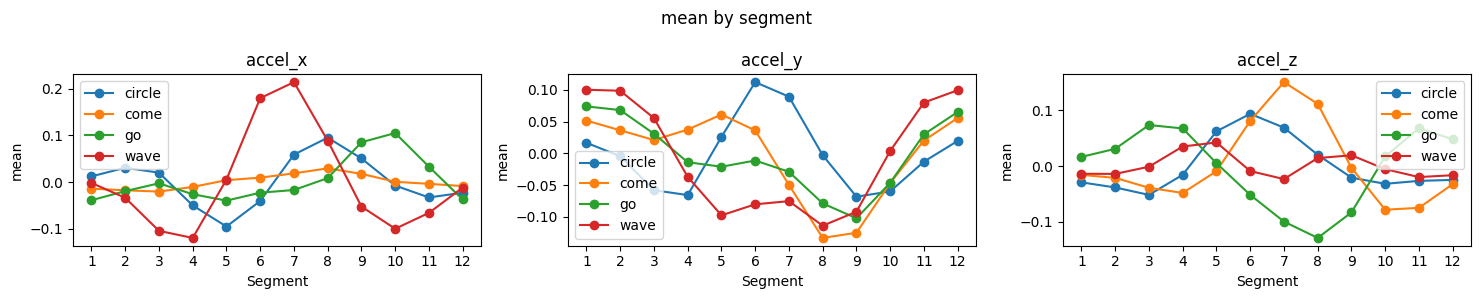

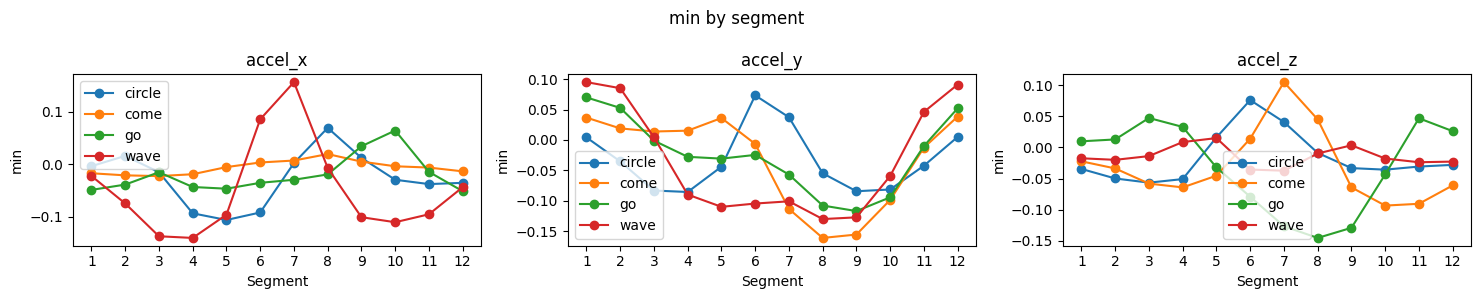

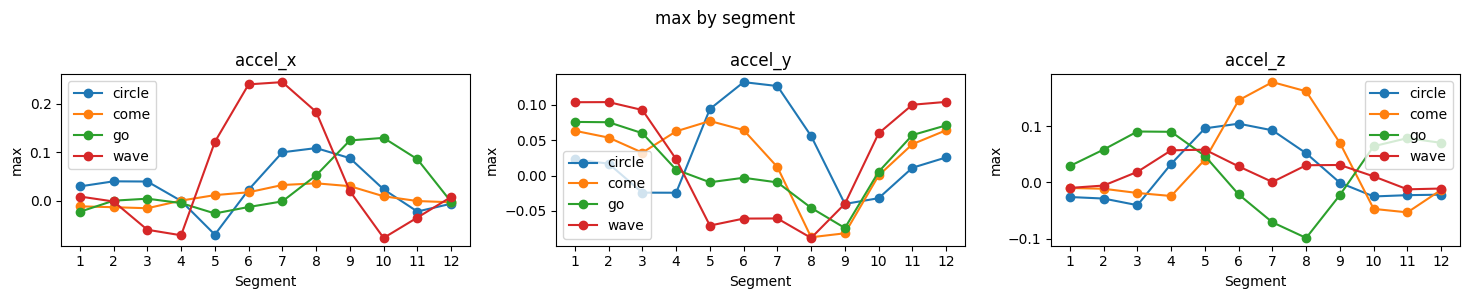

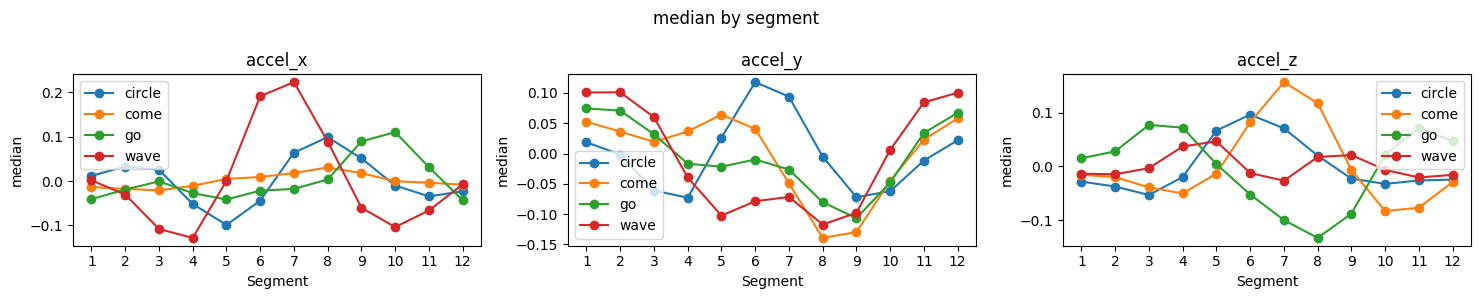

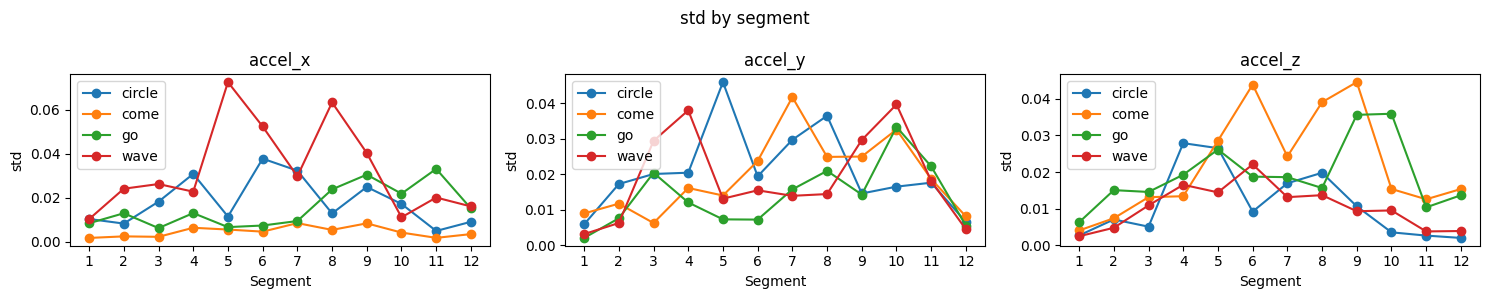

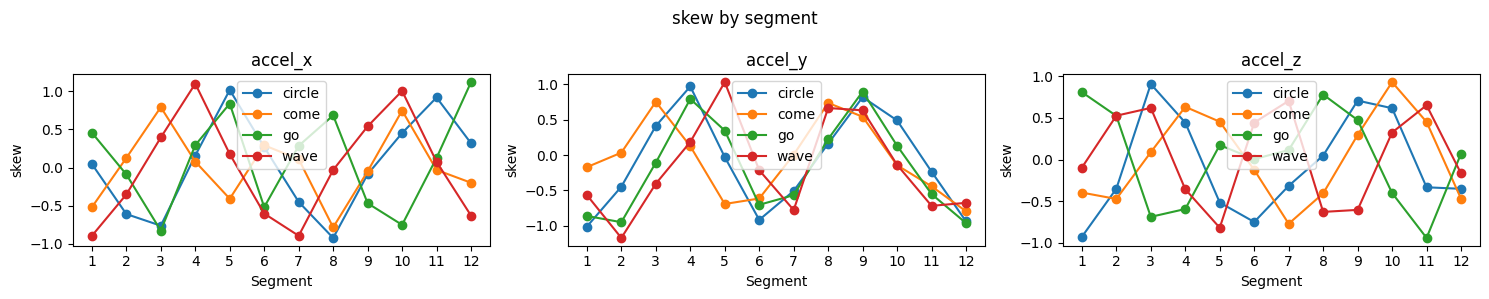

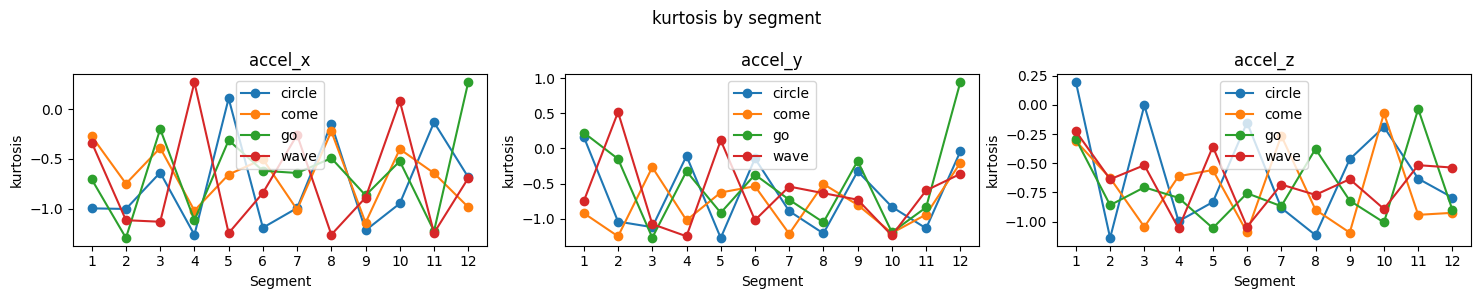

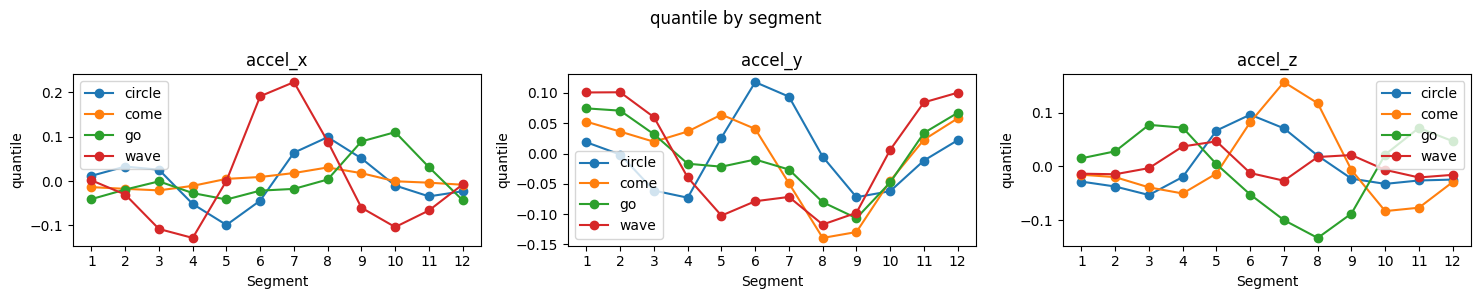

In [37]:
# Visualisting Feature extraction for feature selection - Ashley Hunt - psyah10

show_trends(extracted_features)

In [38]:
# Visualisting individual feature extraction for selection - Ashley Hunt - psyah10

def show_trend(dataframe, function, charts_per_gesture=4):
      
      for g in get_gestures():
            if len(dataframe.loc[dataframe["gesture"] == g]) == 0:
                  continue
            plt.figure(figsize=(charts_per_gesture * 4, 3))
            plt.title(f"{charts_per_gesture} {g}'s {function}")
            for graphs in range(0, charts_per_gesture):
                  plt.subplot(1, charts_per_gesture, graphs + 1)
                  
                  data = dataframe.loc[dataframe["gesture"] == g].iloc[graphs]
                  for col in get_columns()[1:4]:
                        points = []
                        for s in range(1, num_segments + 1):
                              points.append(data[f'{col}_{function}_{s}'])
                        plt.plot(range(1, num_segments + 1), points, marker='o', linestyle='-', label=col)
                  plt.legend()
                  plt.xticks(range(1, num_segments + 1))
            plt.tight_layout()
            plt.show()

In [39]:
# Visualisting Feature extraction for feature selection - Ashley Hunt - psyah10

# for f in feature_functions:
#       show_trend(extracted_features, f, 2)

### Rebalance data
Once again we reblance our data, this time on the total number of observations for each gesture.

In [40]:
# Balance data functions - Ashley Hunt - psyah10

def rebalance_data(dataframe):
      # Find out the minimum number of gestures in a category
      min_gestures = dataframe['gesture'].value_counts().min()

      # Take only the top x gestures
      return dataframe.groupby('gesture').head(min_gestures)


In [41]:
# Re-balance data - Ashley Hunt - psyah10

extracted_features = rebalance_data(extracted_features)

In [42]:
# Principle Component Analysis & Extraction functions - Ashley Hunt - psyah10

from sklearn.decomposition import PCA
import seaborn as sns

def extract_principle_components(dataframe, components=2):
      
      data = dataframe.reset_index()
      gestures = data['gesture']
      data = data.loc[:, (data.columns != 'gesture') & (data.columns != 'index')]

      pca = PCA(n_components=components)
      principal_components = pca.fit_transform(data)
      cols = [f'principal component {i}' for i in range(1, components + 1)]
      principle_df = pd.DataFrame(data = principal_components, columns = cols)
      principle_df['gesture'] = gestures

      return principle_df

def visualise_principle_components(dataframe):
      cols = len(dataframe.columns) - 1
      plt.figure(figsize=(cols * 3, cols * 3))
      sns.pairplot(dataframe, hue="gesture", palette="deep")
      plt.show()

### Principle Component Analysis

We then utilise PCA to do automatic feature selection. This is easy to extract and does not rely on subjective human input.

In [43]:
# Principle Component Analysis & Extraction - Ashley Hunt - psyah10

NUM_PCA_COMPONENTS = 2

principle_features = extract_principle_components(extracted_features, components=NUM_PCA_COMPONENTS)
test_principle_features = extract_principle_components(extracted_test_features, components=NUM_PCA_COMPONENTS)

<Figure size 600x600 with 0 Axes>

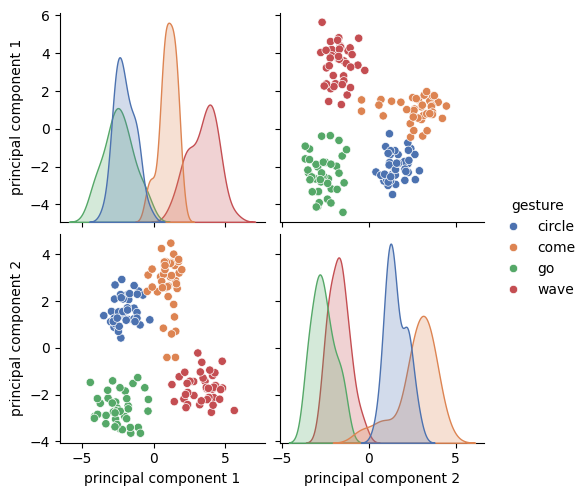

In [44]:
# Visualising Principle Component Analysis - Ashley Hunt - psyah10
visualise_principle_components(principle_features)

## Training
First we prepare out label encoder

In [45]:
# Label encoding functions - Ashley Hunt - psyah10
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

def encode_labels(labels):
    return label_encoder.fit_transform(labels)

def decode_labels(encoded_labels):
    return label_encoder.inverse_transform(encoded_labels)

Then we extract the data that we need

In [46]:
# Data splitting - Ashley Hunt - psyah10
from sklearn.model_selection import train_test_split

PRINCIPLE = True

if PRINCIPLE:
      X = principle_features.loc[:, principle_features.columns != 'gesture']
      Y = encode_labels(principle_features['gesture'])
      UNSEEN_FEATURES = test_principle_features.loc[:, test_principle_features.columns != 'gesture']
      UNSEEN_LABELS = encode_labels(test_principle_features['gesture'])
else:
      X = extracted_features.loc[:, extracted_features.columns != 'gesture']
      Y = encode_labels(extracted_features['gesture'])
      UNSEEN_FEATURES = extracted_test_features.loc[:, extracted_test_features.columns != 'gesture']
      UNSEEN_LABELS = encode_labels(extracted_test_features['gesture'])

train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=0.3, random_state=42)

### K-means Clustering
As the first, most basic option for classification we consider a K-means clustering algorithm.

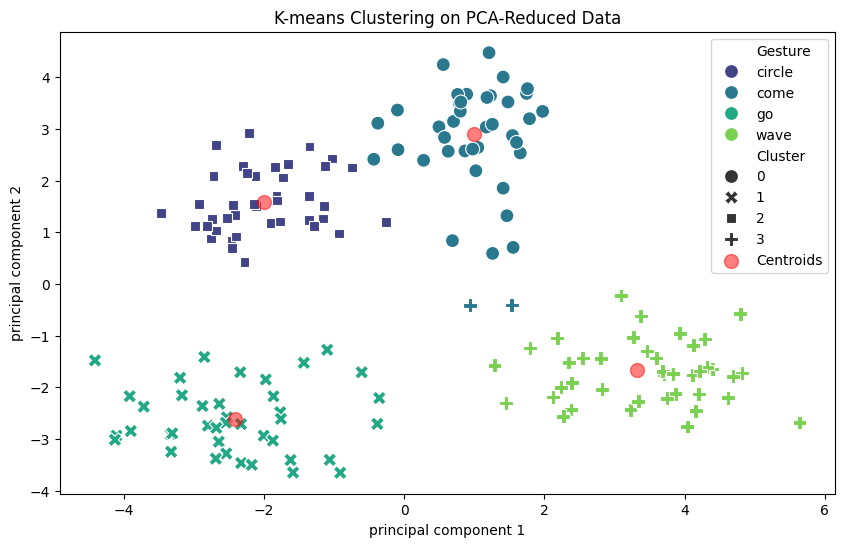

Silhouette Score: 0.6310596924491412


In [73]:
# K-means clustering functions - Ashley Hunt - psyah10

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def kmeans_clustering(dataframe, x, y, k=3):
      kmeans_data = dataframe.copy().reset_index()
      gestures = kmeans_data['gesture']
      kmeans_data = kmeans_data.loc[:, (kmeans_data.columns != 'gesture') & (kmeans_data.columns != 'index')]

      kmeans = KMeans(n_clusters=k, random_state=42)

      kmeans.fit(kmeans_data)
      
      kmeans_data['Cluster'] = kmeans.fit_predict(kmeans_data)
      kmeans_data['Gesture'] = gestures

      plt.figure(figsize=(10, 6))
      sns.scatterplot(x=x, y=y, hue='Gesture', data=kmeans_data, palette='viridis', style='Cluster', s=100)
      plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=100, alpha=0.5, label='Centroids')
      plt.title('K-means Clustering on PCA-Reduced Data')
      plt.xlabel(x)
      plt.ylabel(y)
      plt.legend()
      plt.show()
      
      score = silhouette_score(kmeans_data.drop(['Cluster', 'Gesture'], axis=1), kmeans_data['Cluster'])
      print('Silhouette Score:', score)
      return kmeans

# K-means clustering analysis - Ashley Hunt - psyah10
kmeans = kmeans_clustering(principle_features, x='principal component 1', y='principal component 2', k=num_gestures())

In [123]:
# Confusion matrix display functions - Ashley Hunt - psyah10
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_true, y_pred):
      
      labels = decode_labels(unique_labels(UNSEEN_LABELS))
      cm_df = pd.DataFrame(confusion_matrix(y_true, y_pred), index=labels, columns=labels)

      plt.figure(figsize=(7, 5))
      sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues', cbar='False')  # `annot=True` to annotate cells
      plt.title('Confusion Matrix')
      plt.ylabel('Actual')
      plt.xlabel('Predicted')
      plt.tight_layout()
      plt.show()

Accuracy: 0.275
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.09      0.10      0.10        10
           3       1.00      1.00      1.00        10

    accuracy                           0.28        40
   macro avg       0.27      0.28      0.27        40
weighted avg       0.27      0.28      0.27        40



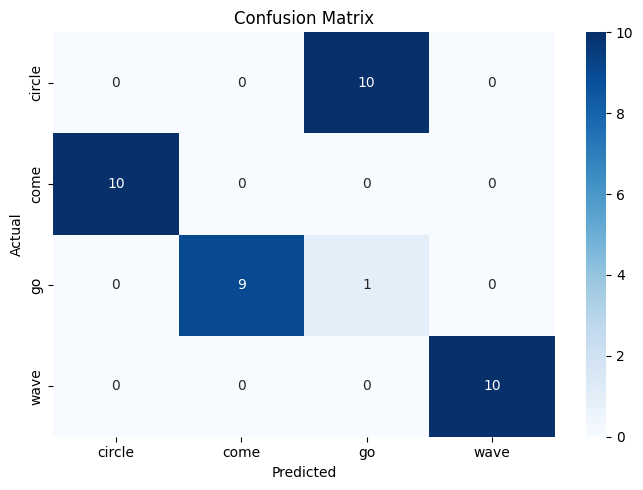

In [124]:
from sklearn.metrics import accuracy_score, classification_report

kmeans_prediction = kmeans.predict(UNSEEN_FEATURES)

print(f"Accuracy: {accuracy_score(UNSEEN_LABELS, kmeans_prediction)}")
print(classification_report(UNSEEN_LABELS, kmeans_prediction))

show_confusion_matrix(UNSEEN_LABELS, kmeans_prediction)

### Random Forest

In [48]:
# Random Forest Training - Ashley Hunt - psyah10
from sklearn.ensemble import RandomForestClassifier

rfc_model = RandomForestClassifier(n_estimators=100, random_state=42)
rfc_model.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

Accuracy: 0.9791666666666666
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.91      1.00      0.95        10
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



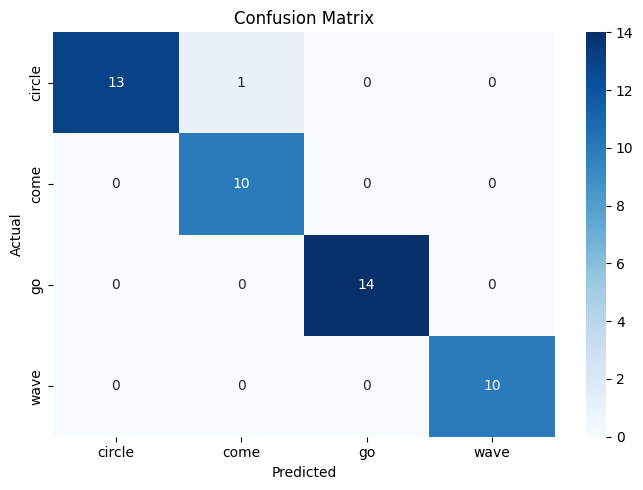

In [126]:
# Random Forest Evaluation - Ashley Hunt - psyah10

rfc_prediction = rfc_model.predict(test_features)

print(f"Accuracy: {accuracy_score(test_labels, rfc_prediction)}")
print(classification_report(test_labels, rfc_prediction))
show_confusion_matrix(test_labels, rfc_prediction)

Accuracy: 0.975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10
           3       1.00      1.00      1.00        10

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



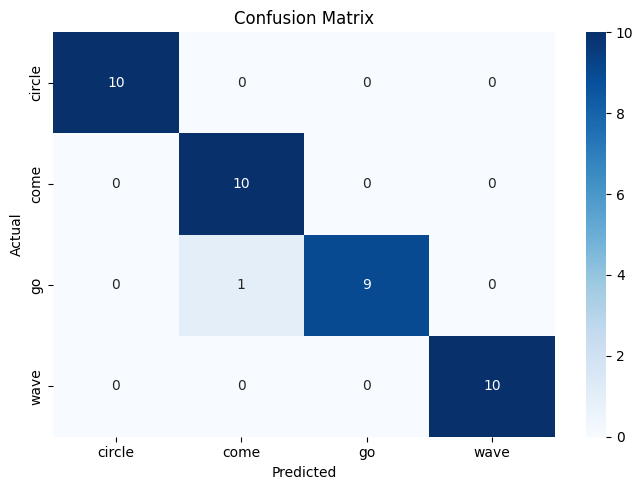

In [127]:
# Random Forest Validation - Ashley Hunt - psyah10
rfc_unseen_feature_prediction = rfc_model.predict(UNSEEN_FEATURES)

print(f"Accuracy: {accuracy_score(UNSEEN_LABELS, rfc_unseen_feature_prediction)}")
print(classification_report(UNSEEN_LABELS, rfc_unseen_feature_prediction))
show_confusion_matrix(UNSEEN_LABELS, rfc_unseen_feature_prediction)

### Support Vector Machines 

In [52]:
# Support Vector Machines Training - Ashley Hunt - psyah10
from sklearn import svm

svm_model = svm.SVC(kernel='linear') # Linear Kernel
svm_model.fit(train_features, train_labels)

SVC(kernel='linear')

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



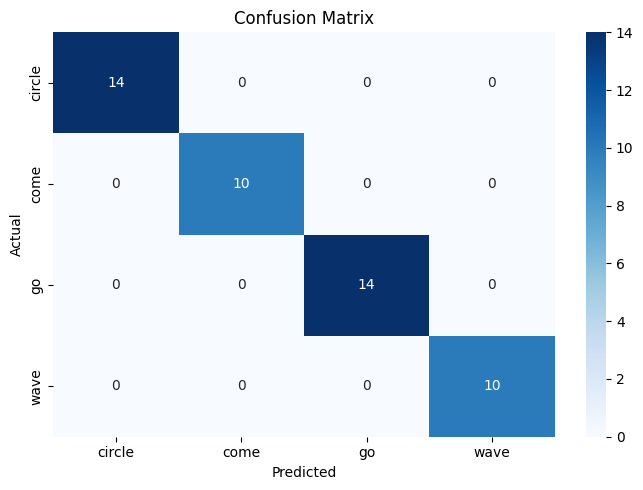

In [128]:
# Support Vector Machines Evaluation - Ashley Hunt - psyah10
svm_y_pred = svm_model.predict(test_features)

print(f"Accuracy: {accuracy_score(test_labels, svm_y_pred)}")
print(classification_report(test_labels, svm_y_pred))
show_confusion_matrix(test_labels, svm_y_pred)

Accuracy: 0.975
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      1.00      1.00        10
           2       1.00      0.90      0.95        10
           3       1.00      1.00      1.00        10

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



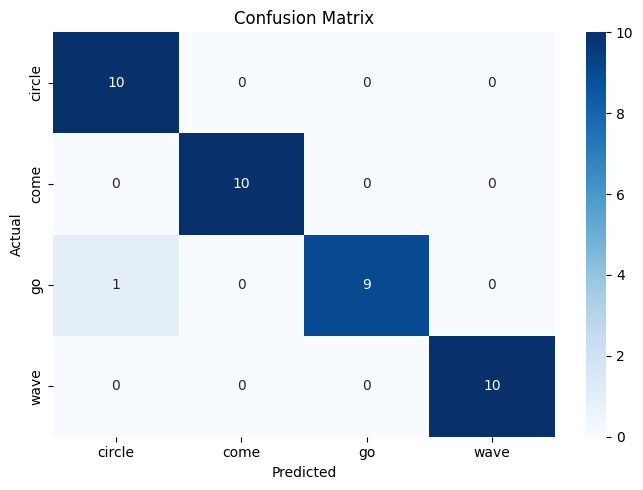

In [129]:
# Support Vector Machines Validation - Ashley Hunt - psyah10

svm_unseen_feature_prediction = svm_model.predict(UNSEEN_FEATURES)

print(f"Accuracy: {accuracy_score(UNSEEN_LABELS, svm_unseen_feature_prediction)}")
print(classification_report(UNSEEN_LABELS, svm_unseen_feature_prediction))
show_confusion_matrix(UNSEEN_LABELS, svm_unseen_feature_prediction)

### XGB

In [68]:
# XGB - Amit Kumar
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(random_state=42)

### LSTM

In [70]:
# LSTM - Amit Kumar
from keras.models import Sequential
from keras.layers import LSTM, Dense

### KNN

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
Best cross-validation score: 1.00
Test set accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        10

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



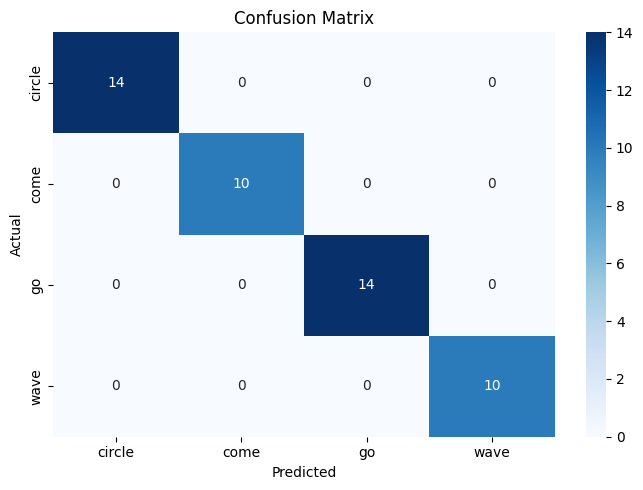

In [130]:
# KNN - Shreeya Kumbhoje
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Initialize the scaler and the KNN classifier
scaler = StandardScaler()
knn = KNeighborsClassifier()
 
# Create a pipeline that first scales the data then applies KNN
pipeline = Pipeline([('scaler', scaler), ('knn', knn)])

# Parameters of the KNN classifier to tune
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],  # Example range; can be expanded based on computational resources
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}
 
# Grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(train_features, train_labels)
 
# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
 
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
test_pred = best_model.predict(test_features)
print("Test set accuracy: ", accuracy_score(test_labels, test_pred))
print(classification_report(test_labels, test_pred))
show_confusion_matrix(test_labels, test_pred)

In [77]:
knn_unseen_test_pred = best_model.predict(UNSEEN_FEATURES)
print("Test set accuracy: ", accuracy_score(UNSEEN_LABELS, knn_unseen_test_pred))
print(classification_report(UNSEEN_LABELS, knn_unseen_test_pred))
print(confusion_matrix(UNSEEN_LABELS, knn_unseen_test_pred))

Test set accuracy:  0.975
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.91      1.00      0.95        10
           2       1.00      0.90      0.95        10
           3       1.00      1.00      1.00        10

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40

[[10  0  0  0]
 [ 0 10  0  0]
 [ 0  1  9  0]
 [ 0  0  0 10]]


## Hyperparameter Tuning

In [55]:
# Ashley Hunt - psyah10
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
               }
rf = RandomForestClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

DO_MODEL_TUNING = True

if(DO_MODEL_TUNING):
      rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, error_score='raise')
      rf_random.fit(train_features, train_labels)
      
      rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [56]:
from sklearn.metrics import balanced_accuracy_score

best_params = rf_random.best_params_
best_estimator = rf_random.best_estimator_

y_pred = best_estimator.predict(test_features)
balanced_accuracy = balanced_accuracy_score(test_labels, y_pred)

print("Best Parameters:", best_params)
print("Balanced Accuracy:", balanced_accuracy)

Best Parameters: {'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 80, 'bootstrap': True}
Balanced Accuracy: 0.9821428571428572


In [57]:
unseen_feature_prediction = best_estimator.predict(UNSEEN_FEATURES)
print("Prediction on unseen data:", decode_labels(unseen_feature_prediction))

Prediction on unseen data: ['circle' 'circle' 'circle' 'circle' 'circle' 'circle' 'circle' 'circle'
 'circle' 'circle' 'come' 'come' 'come' 'come' 'come' 'come' 'come' 'come'
 'come' 'come' 'come' 'go' 'go' 'go' 'go' 'go' 'go' 'go' 'go' 'go' 'wave'
 'wave' 'wave' 'wave' 'wave' 'wave' 'wave' 'wave' 'wave' 'wave']


In [58]:
# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     errors = abs(predictions - test_labels)
#     mape = 100 * np.mean(errors / test_labels)
#     accuracy = 100 - mape
#     print('Model Performance')
#     print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
#     return accuracy

# base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
# base_model.fit(features, encoded_labels)
# base_accuracy = evaluate(base_model, test_features, test_labels)

# best_random = rf_random.best_estimator_
# random_accuracy = evaluate(best_random, test_features, test_labels)

# print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

In [59]:
# Amit Kumar
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

# for train_index, test_index in sss.split(features, encoded_labels):
#     train_features, test_features = features[train_index], features[test_index]
#     train_labels, test_labels = encoded_labels[train_index], encoded_labels[test_index]
#     print(f"  Test:  index={test_index}")
#     print(f"  Train: index={train_index}")
    
# rfc = RandomForestClassifier(random_state=42)
 
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
 
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='balanced_accuracy')
# grid_search.fit(train_features, train_labels)

# best_params = grid_search.best_params_
# best_estimator = grid_search.best_estimator_
 
# y_pred = best_estimator.predict(test_features)
# balanced_accuracy = balanced_accuracy_score(test_labels, y_pred)
# print("Best Parameters:", best_params)
# print("Balanced Accuracy:", balanced_accuracy)

In [60]:
# Amit Kumar
# from xgboost import XGBClassifier
 
# sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
 
# for train_index, test_index in sss.split(X, y):
#     train_features, test_features = X[train_index], X[test_index]
#     train_labels, test_labels = y[train_index], y[test_index]
    
# xgb_classifier = XGBClassifier(random_state=42)
 
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }
 
# grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='balanced_accuracy', cv=5)
# grid_search.fit(train_features, train_labels)
 
# best_params = grid_search.best_params_
# best_estimator = grid_search.best_estimator_
 
# y_pred = best_estimator.predict(test_features)
 
# balanced_accuracy = balanced_accuracy_score(test_labels, y_pred)
# print("Best Parameters:", best_params)
# print("Balanced Accuracy:", balanced_accuracy)

In [61]:
rfc = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [250], #'n_estimators': [50, 100, 150]
    'max_depth': [None], #'max_depth': [None, 10, 20]
    'min_samples_split': [10], #'min_samples_split': [2, 5, 10]
    'min_samples_leaf': [2] #'min_samples_leaf': [1, 2, 4]
}
 
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3,scoring='balanced_accuracy')
grid_search.fit(train_features, train_labels)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
 
y_pred = best_estimator.predict(test_features)
balanced_accuracy = balanced_accuracy_score(test_labels, y_pred)
print("Best Parameters:", best_params)
print("Balanced Accuracy:", balanced_accuracy)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 250}
Balanced Accuracy: 0.9821428571428572
